**Evan Kluger - ATP PREDICTING WINNER MODEL**

**Problem Statement**

**Can We Use a Data Driven Approach to Predict ATP Tour Match Winners?**

##**Getting Started -> Imports, Data Collection, and more**


**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Imports and Packages**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from keras.layers import LeakyReLU, BatchNormalization
from keras.regularizers import l1, l2
from keras.optimizers import RMSprop, Adagrad
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
import warnings
from sklearn.exceptions import ConvergenceWarning
import xgboost as xgb

pd.options.mode.chained_assignment = None

**Uploading the Match Data to Individual Dataframes**

In [ ]:
#Gatheing dataframes from Seperate CSV Files

dataframes = {}
folder_path = '/content/drive/My Drive/Data Driven Problem Solving/ATP Tennis Model/ATP DATA/'

for year in range(1968, 2024):
    file_path = f'{folder_path}/atp_matches_{year}.csv'
    dataframes[year] = pd.read_csv(file_path)

**Concating Match Dataframes Together**

In [ ]:
all_atp_matches = pd.concat(dataframes.values(), ignore_index=True)

#Uncomment the line below to see info on the all_atp_matches dataframe
all_atp_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191890 entries, 0 to 191889
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          191890 non-null  object 
 1   tourney_name        191890 non-null  object 
 2   surface             188953 non-null  object 
 3   draw_size           191055 non-null  float64
 4   tourney_level       191890 non-null  object 
 5   tourney_date        191890 non-null  int64  
 6   match_num           191890 non-null  int64  
 7   winner_id           191890 non-null  int64  
 8   winner_seed         70911 non-null   float64
 9   winner_entry        16743 non-null   object 
 10  winner_name         191890 non-null  object 
 11  winner_hand         191878 non-null  object 
 12  winner_ht           174986 non-null  float64
 13  winner_ioc          191882 non-null  object 
 14  winner_age          190579 non-null  float64
 15  loser_id            191890 non-nul

**Create Dataset for Only 1991 and beyond**

Only 1991 matches and beyond offered valuable statistics. Before then just the matches were recorded in the dataset.

In [ ]:
#Create one Dataframe for al Matches 1991 and beyond

dataframes_1991_2023 = {}

for year in range(1991, 2024):
    file_path = f'/content/drive/My Drive/Data Driven Problem Solving/ATP Tennis Model/ATP DATA/atp_matches_{year}.csv'
    dataframes_1991_2023[year] = pd.read_csv(file_path)

atp_matches_91_23 = pd.concat(dataframes_1991_2023.values(), ignore_index=True)
atp_matches_91_23['tourney_date'] = pd.to_datetime(atp_matches_91_23['tourney_date'], format='%Y%m%d')

#Uncomment the line below to see info on the atp_matches_91_23 dataset
#atp_matches_91_23.info()

#**Exploratory Data Analysis**

##**Describing Basic Statistics**

In [ ]:
atp_matches_91_23.describe()

,draw_size,match_num,winner_id,winner_seed,winner_ht,winner_age,loser_id,loser_seed,loser_ht,loser_age,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
count,105269.000000,105269.000000,105269.000000,42625.000000,102747.000000,105262.00000,105269.000000,23436.000000,100321.00000,105245.000000,...,94949.000000,94949.000000,94949.000000,94950.000000,94949.000000,94949.000000,104069.000000,103081.000000,102723.000000,101740.000000
mean,53.468315,73.324483,106941.974617,6.924762,185.728148,25.77590,107057.553610,8.289555,185.21801,25.887315,...,48.087563,31.959968,14.974607,12.206677,4.809529,8.732172,80.655940,1431.357049,119.107201,897.886141
std,38.668062,113.612941,16433.585749,6.229143,6.661455,3.81208,16614.887635,6.737642,6.60963,3.933595,...,19.381402,14.449570,7.208813,4.132242,3.275270,4.132782,134.436094,1755.564874,179.981868,1005.640566
min,2.000000,1.000000,100284.000000,1.000000,160.000000,14.30000,100282.000000,1.000000,160.00000,14.500000,...,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,32.000000,10.000000,102152.000000,3.000000,180.000000,23.00000,102158.000000,4.000000,180.00000,23.000000,...,34.000000,22.000000,10.000000,9.000000,2.000000,6.000000,18.000000,530.000000,37.000000,395.000000
50%,32.000000,24.000000,103602.000000,5.000000,185.000000,25.50000,103582.000000,6.000000,185.00000,25.700000,...,45.000000,30.000000,14.000000,11.000000,4.000000,8.000000,46.000000,880.000000,70.000000,660.000000
75%,64.000000,76.000000,104871.000000,8.000000,190.000000,28.30000,104926.000000,11.000000,190.00000,28.500000,...,58.000000,40.000000,19.000000,15.000000,7.000000,11.000000,89.000000,1600.000000,119.000000,1040.000000
max,128.000000,1701.000000,212051.000000,35.000000,211.000000,43.60000,212044.000000,35.000000,211.00000,46.000000,...,328.000000,284.000000,101.000000,91.000000,28.000000,38.000000,2101.000000,16950.000000,2159.000000,16950.000000


**Analysis:** The analysis of the overall raw data using the decribe method is useful in gaining an initial understanding behind the values and meaning of the different columns of the dataset.

##**General Bar Plots**

**Wins by Country**

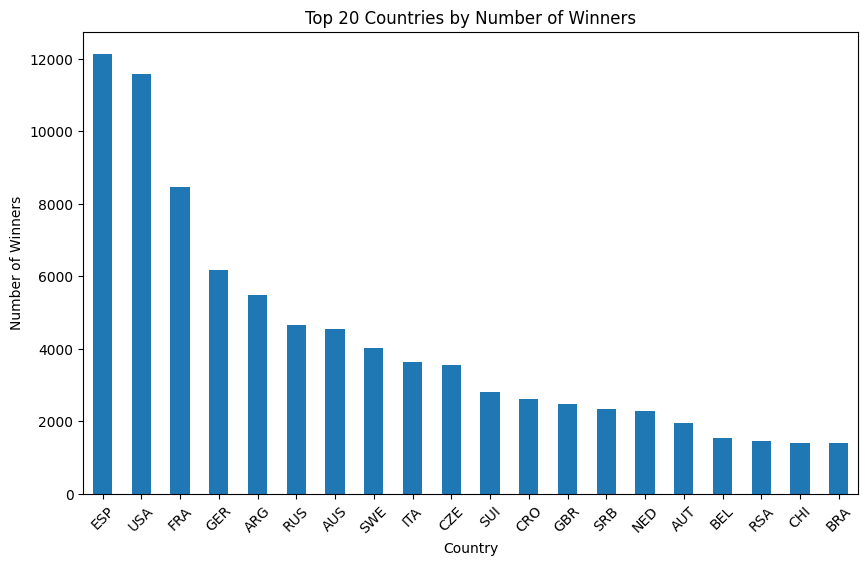

In [ ]:
plt.figure(figsize=(10, 6))
atp_matches_91_23['winner_ioc'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Countries by Number of Winners')
plt.xlabel('Country')
plt.ylabel('Number of Winners')
plt.xticks(rotation=45)
plt.show()

**Analysis:**
Besides for being a cool overview of Tennis History, the wins by location gives an initial understaning and idea behind using the player's country of origin in the model.

**ATP Tour Biggest Tournanments**

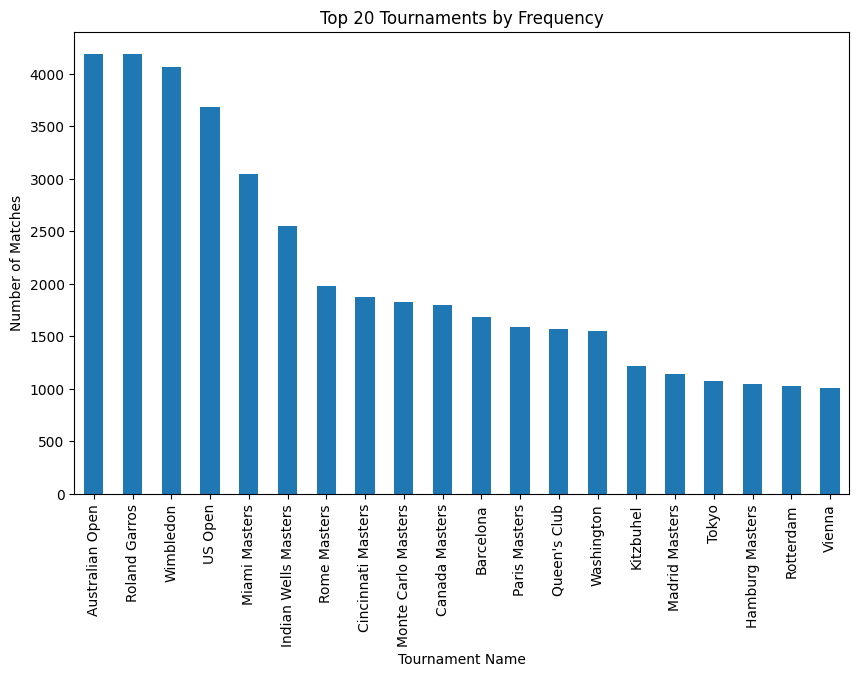

In [ ]:
plt.figure(figsize=(10, 6))
atp_matches_91_23['tourney_name'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Tournaments by Frequency')
plt.xlabel('Tournament Name')
plt.ylabel('Number of Matches')
plt.show()

**Analysis:**
This plot is helpful in understanding the most popular and frequent tournaments in the dataset. This is helpful if there are trends in the different tournaments such as if a tournament favors a different play styles, players, or certain statistics.

**Wins by Seed vs Not-Seed**

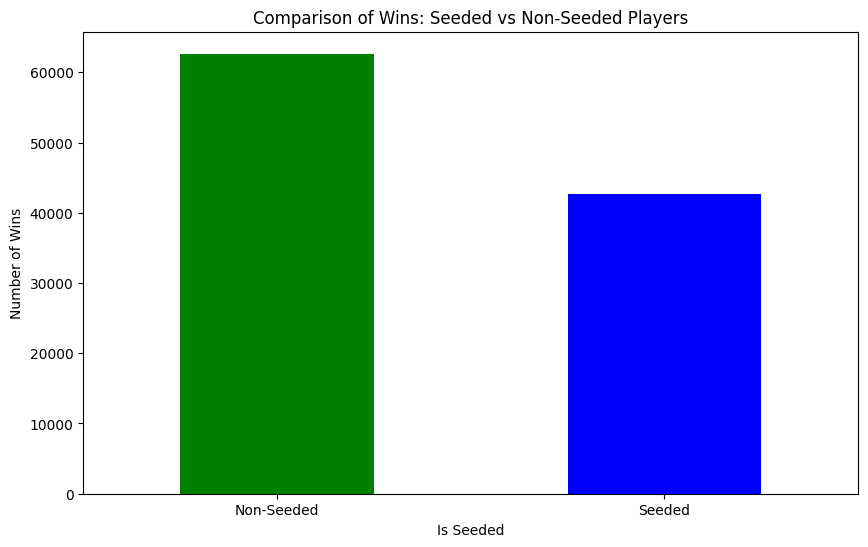

In [ ]:
plt.figure(figsize=(10, 6))
atp_matches_91_23['winner_seed'].notnull().value_counts().plot(kind='bar', color=['green', 'blue'])
plt.title('Comparison of Wins: Seeded vs Non-Seeded Players')
plt.xlabel('Is Seeded')
plt.ylabel('Number of Wins')
plt.xticks(ticks=[0, 1], labels=['Non-Seeded', 'Seeded'], rotation=0)
plt.show()

**Analysis:**
The comparision of wins based on a player being seeded or not gives an intial difference and understanding behind the meaning of seeded vs non-seeded.

**Comparision of Statistics Winner vs Loser**

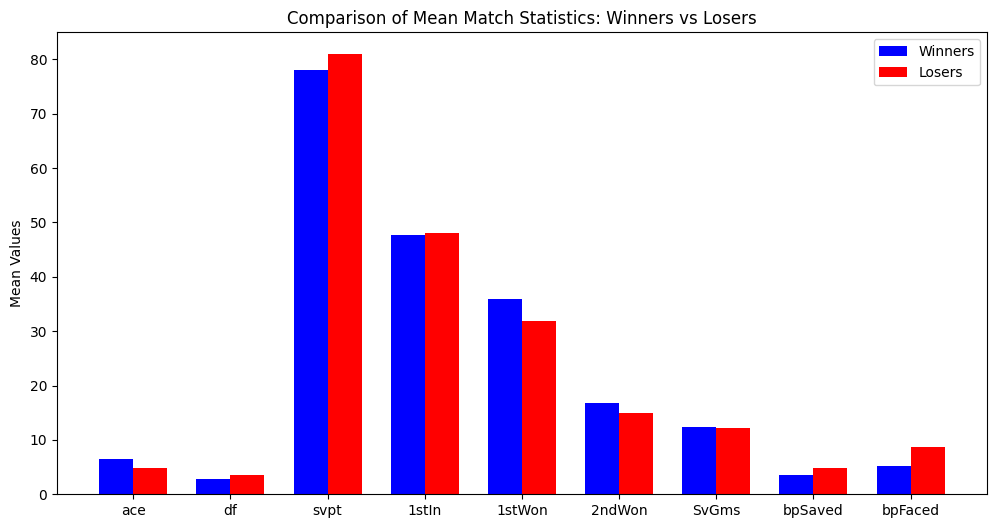

In [ ]:
stats = ['ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']


winner_means = [atp_matches_91_23[f'w_{stat}'].mean() for stat in stats]
loser_means = [atp_matches_91_23[f'l_{stat}'].mean() for stat in stats]

x = range(len(stats))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x, winner_means, width, label='Winners', color='blue')
plt.bar([p + width for p in x], loser_means, width, label='Losers', color='red')

plt.ylabel('Mean Values')
plt.title('Comparison of Mean Match Statistics: Winners vs Losers')
plt.xticks([p + width / 2 for p in x], stats)
plt.legend()

plt.show()

**Analysis:**
The comparision of match specific statistics for winners and losers gives a great overview and intial understanding about some correlations between winners and losers. From here it appears that winners tend to have more aces and serves won while facing less break points and having less double faults. This inoformation is a good starting point for feature selection for model development.

**Win Percentage based on Hand Prefrence**

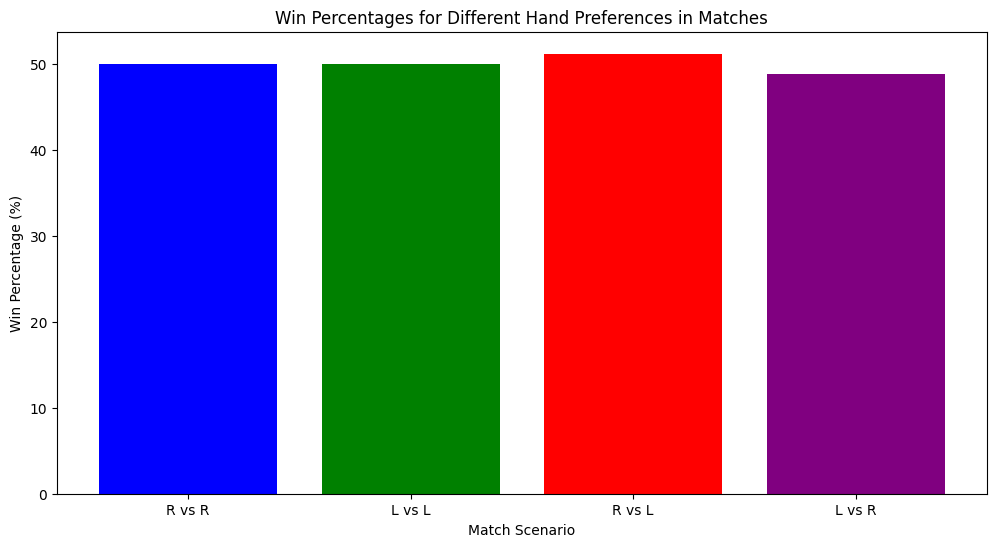

In [ ]:
scenarios = {
    'R vs R': ('R', 'R'),
    'L vs L': ('L', 'L'),
    'R vs L': ('R', 'L'),
    'L vs R': ('L', 'R')
}

win_percentages = {}

for scenario, hands in scenarios.items():
    scenario_matches = atp_matches_91_23[(atp_matches_91_23['winner_hand'] == hands[0]) &
                                       (atp_matches_91_23['loser_hand'] == hands[1])]

    wins = len(scenario_matches)
    total_matches = len(atp_matches_91_23[(atp_matches_91_23['winner_hand'] == hands[0]) &
                                        (atp_matches_91_23['loser_hand'] == hands[1])]) + \
                    len(atp_matches_91_23[(atp_matches_91_23['winner_hand'] == hands[1]) &
                                        (atp_matches_91_23['loser_hand'] == hands[0])])

    win_percentage = (wins / total_matches) * 100 if total_matches > 0 else 0
    win_percentages[scenario] = win_percentage

plt.figure(figsize=(12, 6))
plt.bar(win_percentages.keys(), win_percentages.values(), color=['blue', 'green', 'red', 'purple'])
plt.title('Win Percentages for Different Hand Preferences in Matches')
plt.xlabel('Match Scenario')
plt.ylabel('Win Percentage (%)')
plt.show()

**Analysis:**
The plot above illustrates the win percentage of Righty's vs Lefty's. We see from above that there can potentially be an edge for Righty's when playing against Lefty's.

**Win Percentage of Higher Ranked Players based on Tournemnt Level**

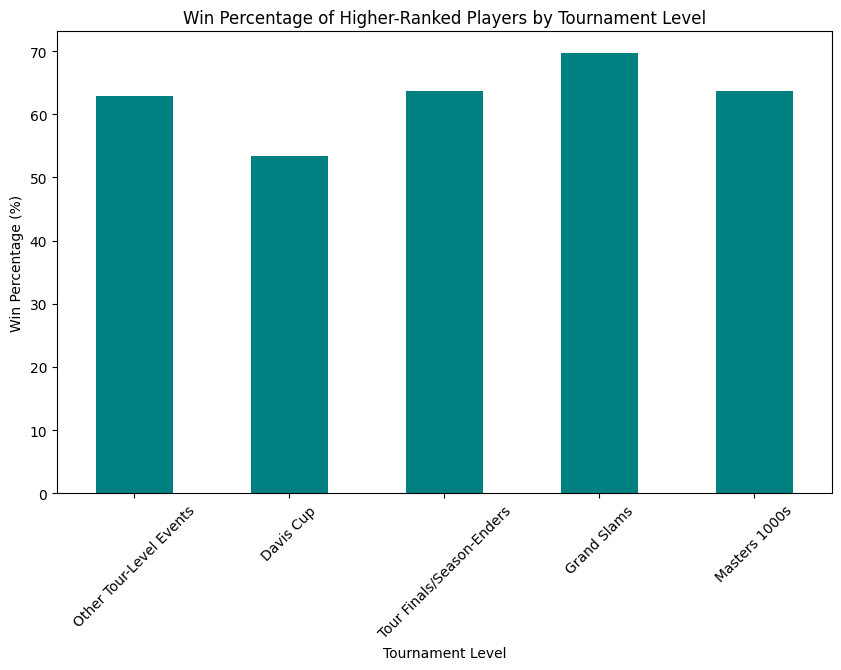

In [ ]:
atp_matches_91_23['higher_ranked_player_won'] = (atp_matches_91_23['winner_rank'] < atp_matches_91_23['loser_rank'])

grouped_by_tourney = atp_matches_91_23.groupby('tourney_level')

win_percentage_by_tourney = grouped_by_tourney['higher_ranked_player_won'].mean() * 100

tourney_labels = {
    'G': 'Grand Slams',
    'M': 'Masters 1000s',
    'A': 'Other Tour-Level Events',
    'C': 'Challengers',
    'S': 'Satellites/ITFs',
    'F': 'Tour Finals/Season-Enders',
    'D': 'Davis Cup'
}

plt.figure(figsize=(10, 6))
win_percentage_by_tourney.plot(kind='bar', color='teal')
plt.title('Win Percentage of Higher-Ranked Players by Tournament Level')
plt.xlabel('Tournament Level')
plt.ylabel('Win Percentage (%)')

plt.xticks(range(len(win_percentage_by_tourney)), [tourney_labels.get(x, x) for x in win_percentage_by_tourney.index], rotation=45)
plt.show()

**Analysis:** The plot above demonstrates the win percentages of the favored player (higher ranked) in different tournaments. This can be useful for model devlopment in passing through the tournment level if it can help the model predict better.

##**Histograms**

**Histogram of Winner Age and Loser Age**

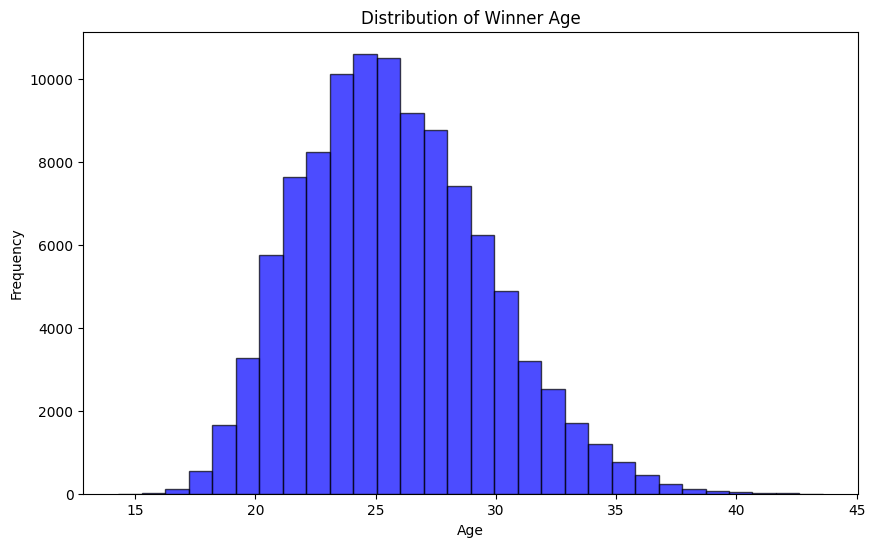

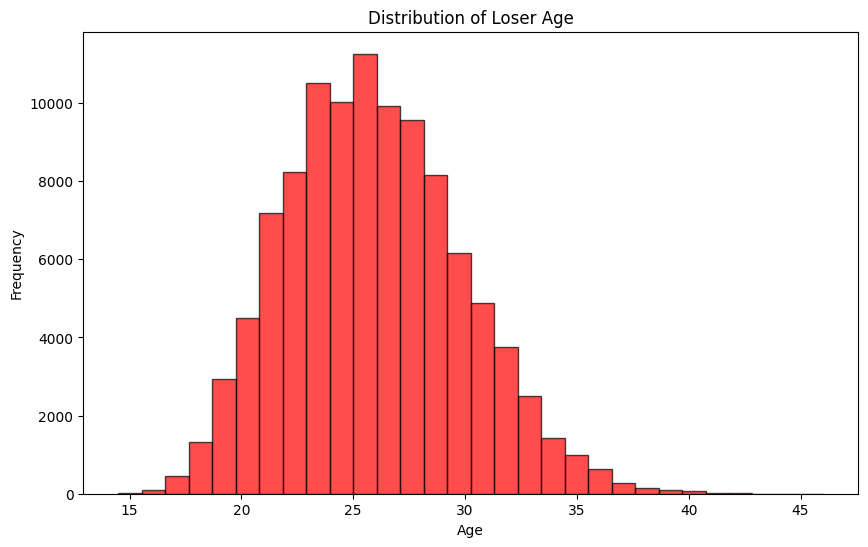

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(atp_matches_91_23['winner_age'], bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Winner Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(atp_matches_91_23['loser_age'], bins=30, color='red', alpha=0.7, edgecolor='black')
plt.title('Distribution of Loser Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

**Analysis:** The comparision of the distributions of winner's and losers's age is helpful in seting a foundation between illustrating how age plays a factor in predicting the winner. While the difference appears slightly, it seems that winner's are more centerly distributed while losers are more spread out indicating that perhaps a middle age is more ideal.

**Histogram of Winner Age and Loser height**

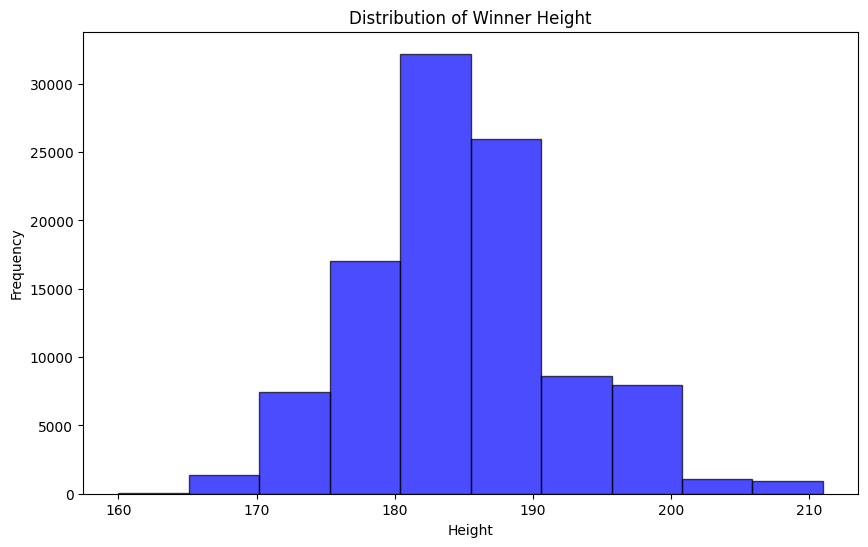

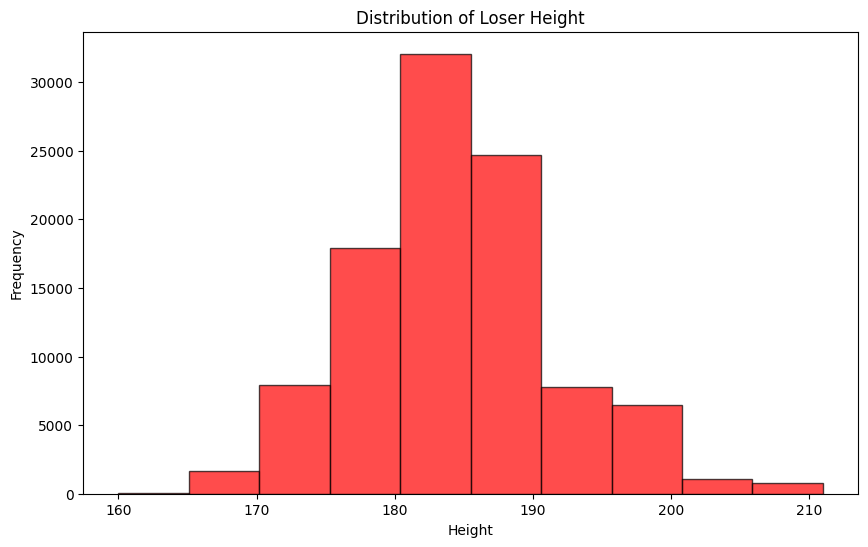

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(atp_matches_91_23['winner_ht'], bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Winner Height')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(atp_matches_91_23['loser_ht'], bins=10, color='red', alpha=0.7, edgecolor='black')
plt.title('Distribution of Loser Height')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

**Analysis:** The comparision of the distributions of winner's and losers's height is helpful in seting a foundation between illustrating how height plays a factor in predicting the winner.

**Histogram of Match Duration**

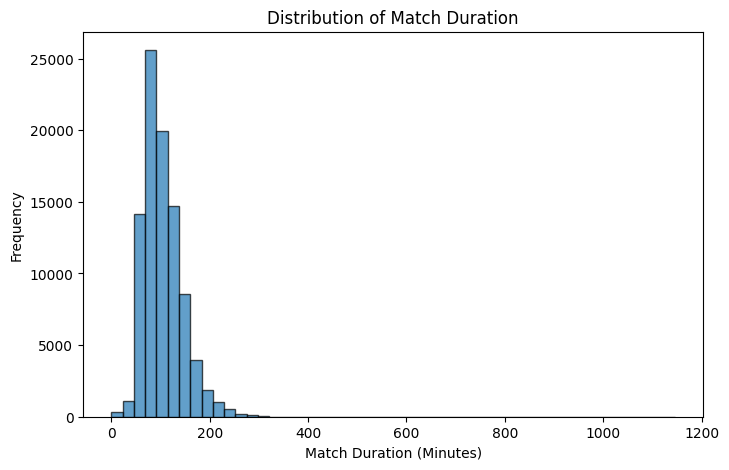

In [ ]:
plt.figure(figsize=(8, 5))
atp_matches_91_23['minutes'].dropna().hist(bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Match Duration')
plt.xlabel('Match Duration (Minutes)')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

**Analysis:** The distriubution of match duration is an interesting statistic in viewing how long tennis matches usually take.

**Histogram of Aces by Winner and Loser**

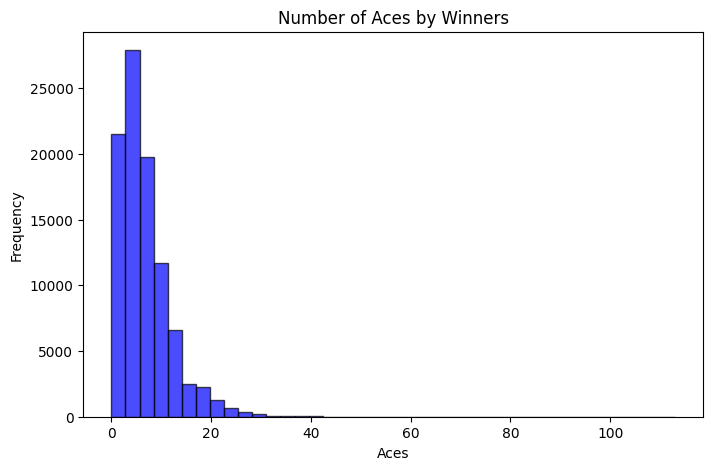

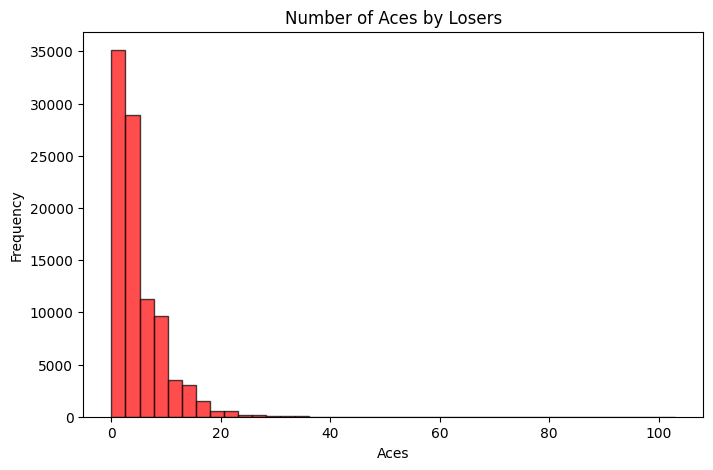

In [ ]:
plt.figure(figsize=(8, 5))
atp_matches_91_23['w_ace'].dropna().hist(bins=40, color='blue', edgecolor='black', alpha=0.7)
plt.title('Number of Aces by Winners')
plt.xlabel('Aces')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

plt.figure(figsize=(8, 5))
atp_matches_91_23['l_ace'].dropna().hist(bins=40, color='red', edgecolor='black', alpha=0.7)
plt.title('Number of Aces by Losers')
plt.xlabel('Aces')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

**Analysis:** The comparision of the distributions of winner's and losers's aces per game is helpful in seting a foundation in how aces plays a factor into predicting the winner of a match. We see from here that winner's distribution is slightly greater than the loser's indicating that aces might have a factor in predicting the winner.

**Height of Avg Player Across the Years**

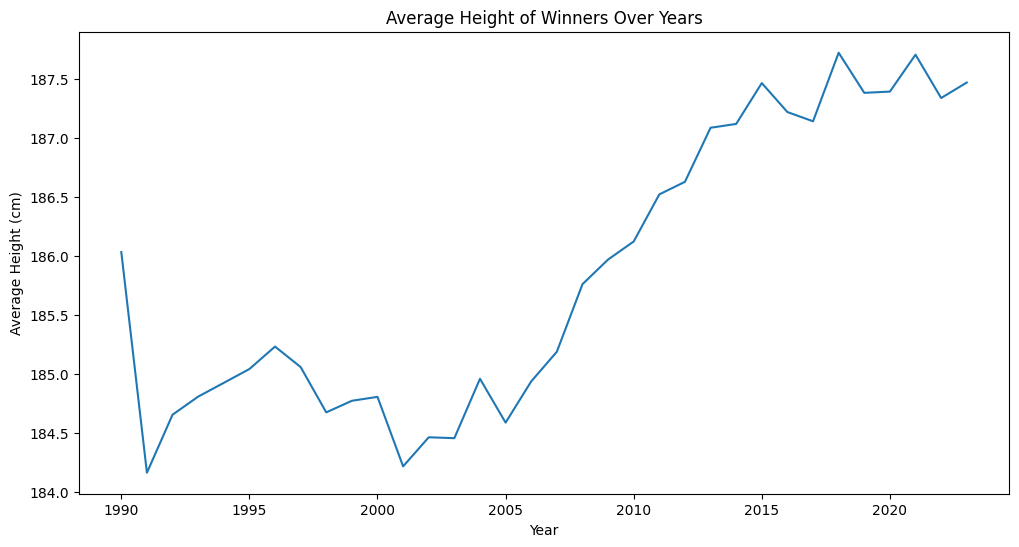

In [ ]:
atp_matches_91_23['year'] = pd.to_datetime(atp_matches_91_23['tourney_date'], format='%Y%m%d').dt.year
avg_height_per_year = atp_matches_91_23.groupby('year')['winner_ht'].mean()
plt.figure(figsize=(12, 6))
avg_height_per_year.plot()
plt.title('Average Height of Winners Over Years')
plt.xlabel('Year')
plt.ylabel('Average Height (cm)')
plt.show()

**Analysis:** The lineplot of height vs time is an interesting statistic in seeing the average height of a tennis player. This is important context for model devlopment to understand to evaluate height against that time periods average as the average height changes over time.

**Age vs Tournment Level Distributions**

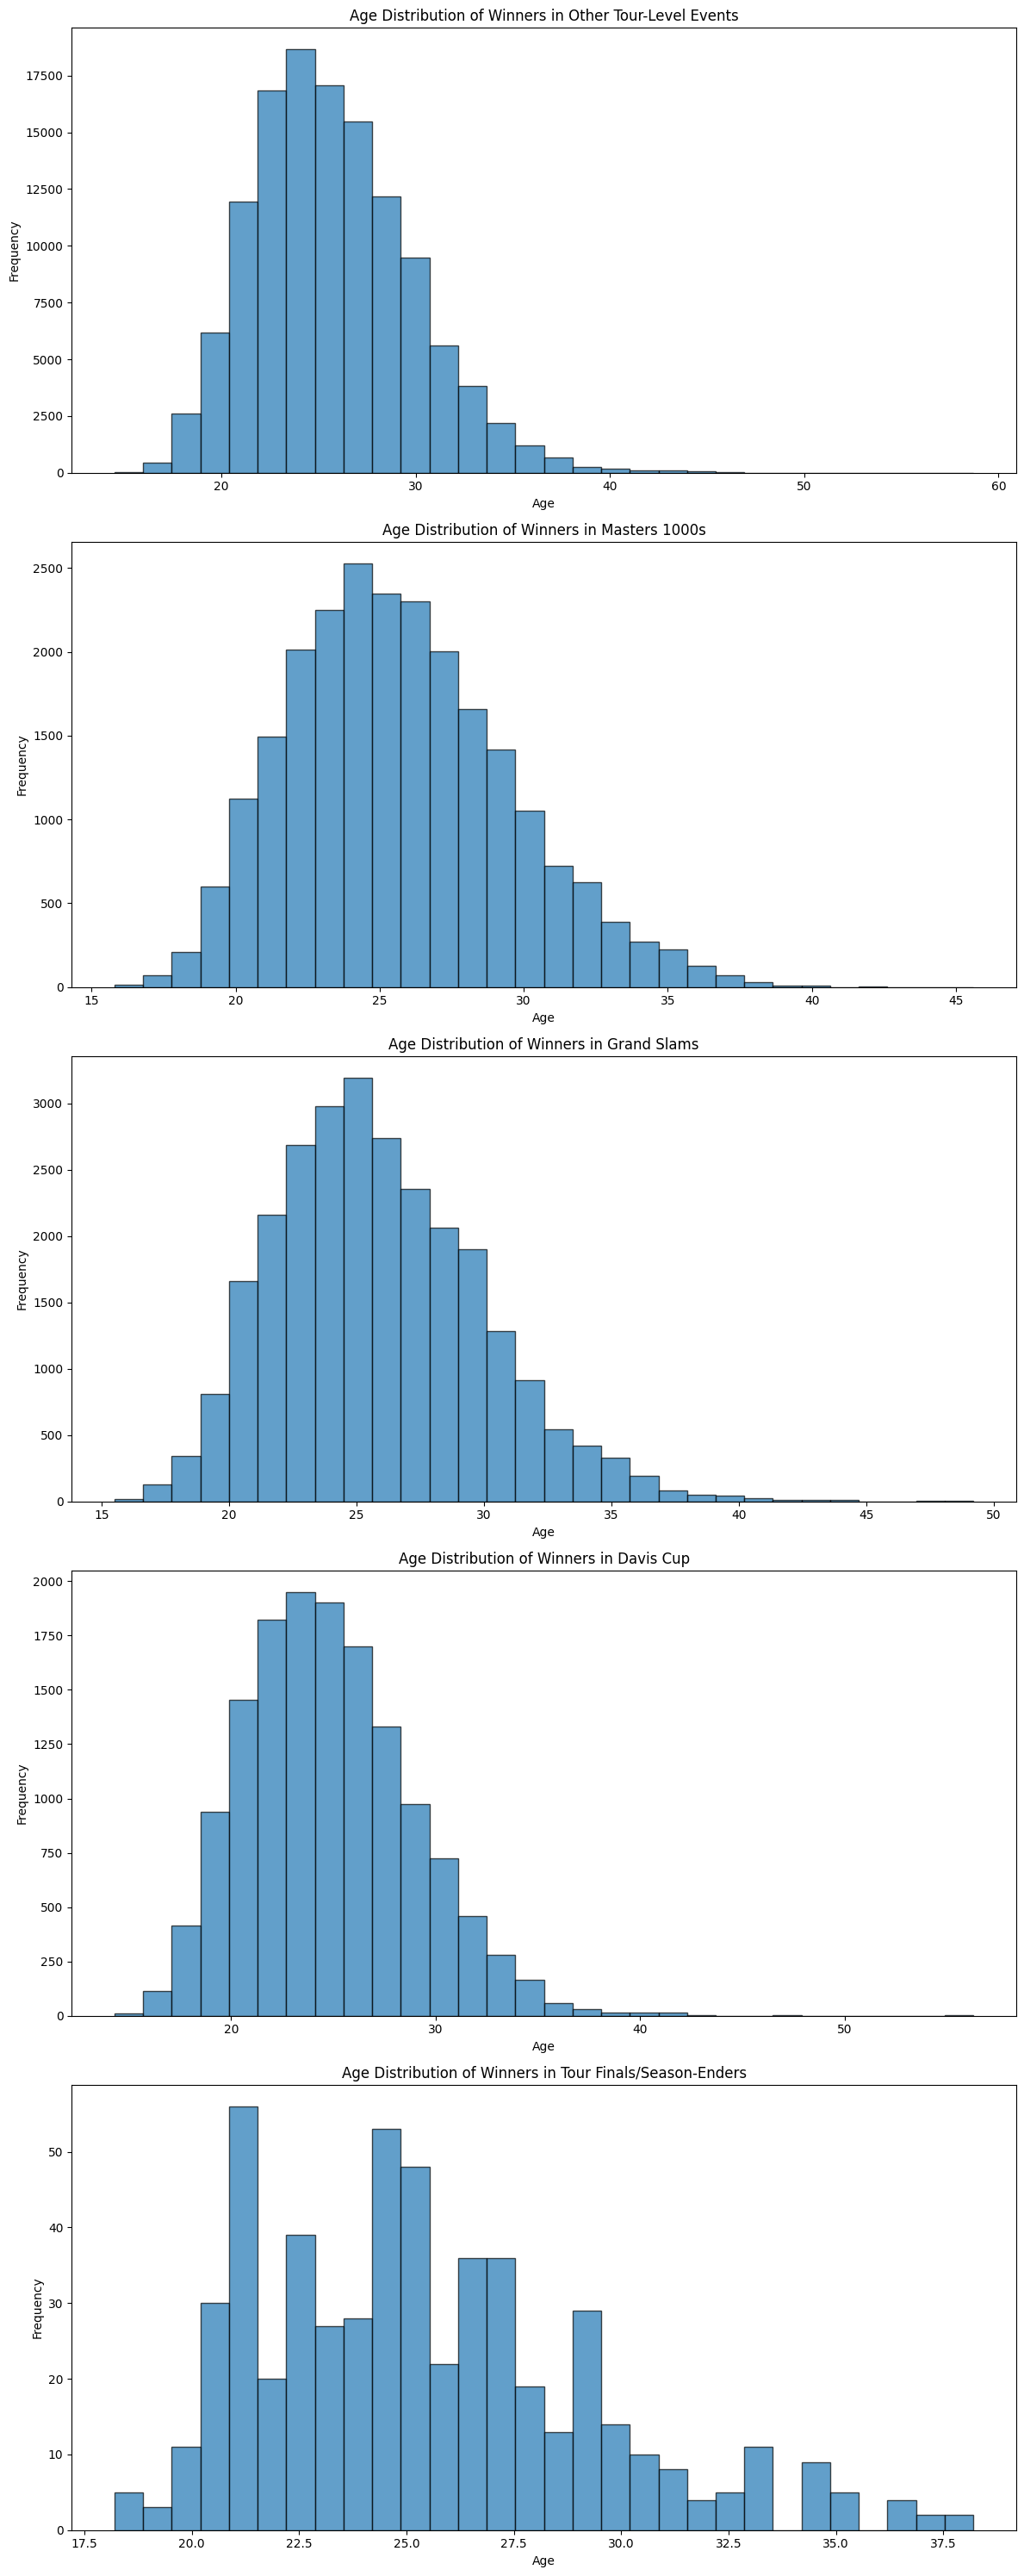

In [ ]:
tourney_labels = {
    'G': 'Grand Slams',
    'M': 'Masters 1000s',
    'A': 'Other Tour-Level Events',
    'C': 'Challengers',
    'S': 'Satellites/ITFs',
    'F': 'Tour Finals/Season-Enders',
    'D': 'Davis Cup'
}

unique_levels = all_atp_matches['tourney_level'].unique()

fig, axes = plt.subplots(nrows=len(unique_levels), ncols=1, figsize=(12, 6 * len(unique_levels)))

for ax, level in zip(axes.flatten(), unique_levels):
    subset = all_atp_matches[all_atp_matches['tourney_level'] == level]
    subset['winner_age'].hist(ax=ax, bins=30, alpha=0.7, edgecolor='black')
    ax.set_title(f'Age Distribution of Winners in {tourney_labels.get(level, "Unknown")}')
    ax.set_xlabel('Age')
    ax.set_ylabel('Frequency')
    ax.grid(False)

plt.tight_layout()
plt.show()

**Analysis:** The comparision of the distributions of age per tournament level is an comparision that can be useful in understanding if age plays in affect differently based on the tournemtn level.

##**Underdog Wins Analysis**

**Scatter Plot of Favorties and Underdog Wins**

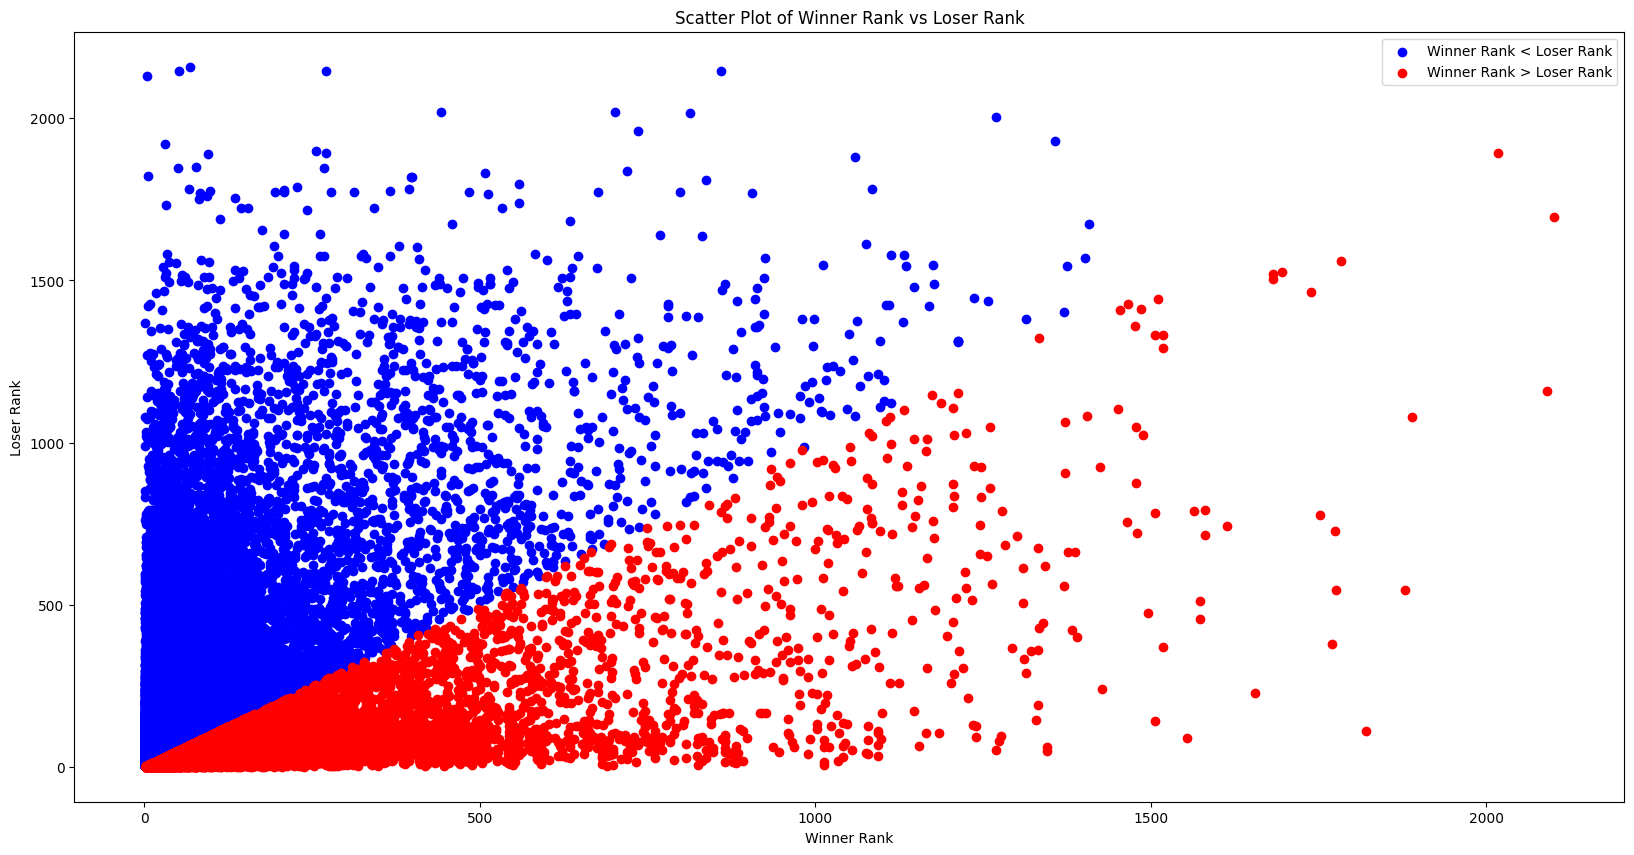

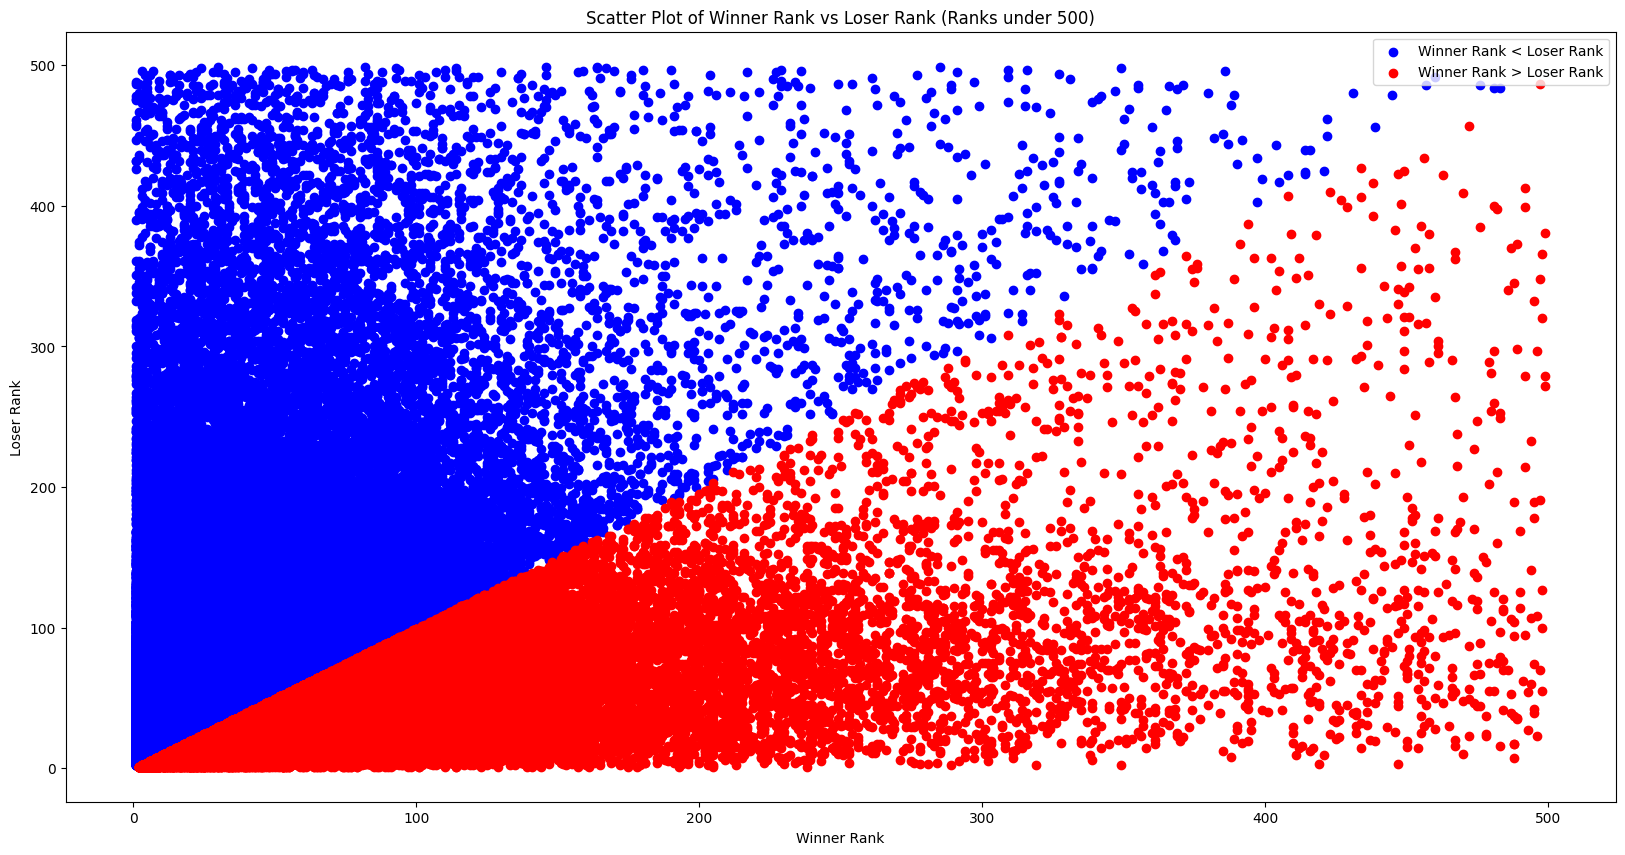

In [ ]:
#Plot 1: All Matches
condition_blue = atp_matches_91_23['winner_rank'] < atp_matches_91_23['loser_rank']
condition_red = atp_matches_91_23['winner_rank'] > atp_matches_91_23['loser_rank']

plt.figure(figsize=(20, 10))
plt.scatter(atp_matches_91_23[condition_blue]['winner_rank'], atp_matches_91_23[condition_blue]['loser_rank'], color='blue', label='Winner Rank < Loser Rank')
plt.scatter(atp_matches_91_23[condition_red]['winner_rank'], atp_matches_91_23[condition_red]['loser_rank'], color='red', label='Winner Rank > Loser Rank')

plt.title('Scatter Plot of Winner Rank vs Loser Rank')
plt.xlabel('Winner Rank')
plt.ylabel('Loser Rank')
plt.legend()
plt.grid(False)
plt.show()

#Plot 1: All Matches where Players are ranked under 500

rank_under_500 = (atp_matches_91_23['winner_rank'] < 500) & (atp_matches_91_23['loser_rank'] < 500)
condition_blue = (atp_matches_91_23['winner_rank'] < atp_matches_91_23['loser_rank']) & rank_under_500
condition_red = (atp_matches_91_23['winner_rank'] > atp_matches_91_23['loser_rank']) & rank_under_500


plt.figure(figsize=(20, 10))
plt.scatter(atp_matches_91_23[condition_blue]['winner_rank'], atp_matches_91_23[condition_blue]['loser_rank'], color='blue', label='Winner Rank < Loser Rank')
plt.scatter(atp_matches_91_23[condition_red]['winner_rank'], atp_matches_91_23[condition_red]['loser_rank'], color='red', label='Winner Rank > Loser Rank')

plt.title('Scatter Plot of Winner Rank vs Loser Rank (Ranks under 500)')
plt.xlabel('Winner Rank')
plt.ylabel('Loser Rank')
plt.legend()
plt.grid(False)
plt.show()


**Analysis:** The scatterplots comparing the amount of games higher ranked players won/lost vs their opponent is useful in seeing an intial view of when underdogs beat their opponents. Ultimately, the job of the model is to predict the underdogs wins as those are the harder matches to predict.

**Bar Plot of Percentage of Underdog Wins based on Category**

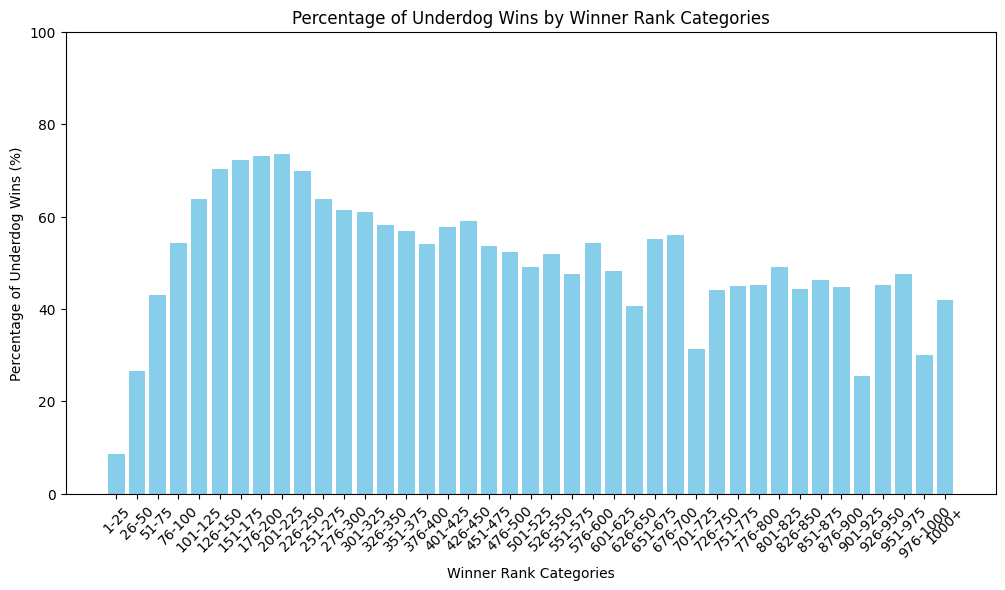

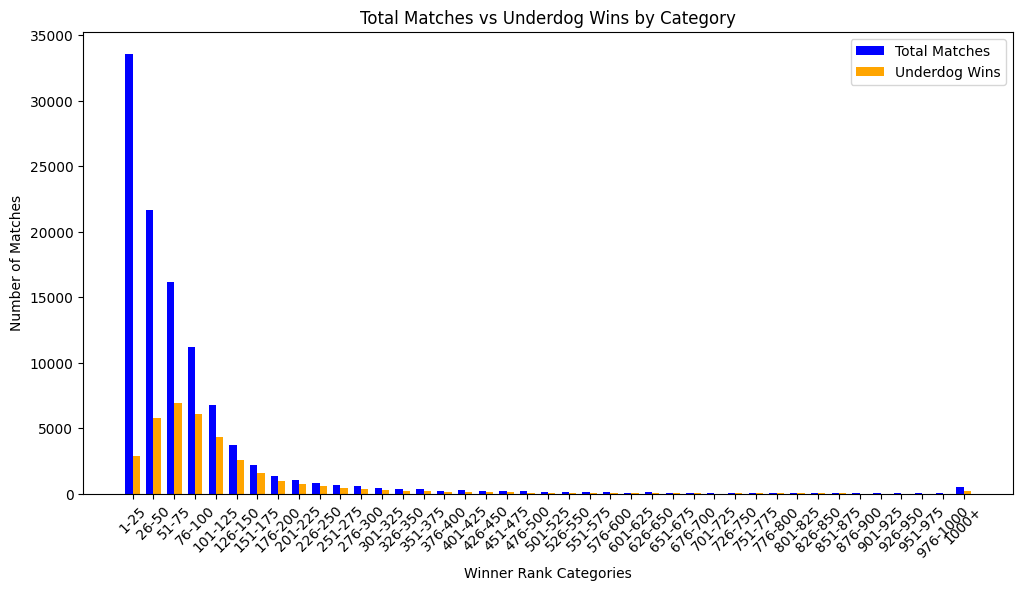

In [ ]:
import matplotlib.pyplot as plt

categories = [(i, i+24) for i in range(1, 1000, 25)]
categories.append((1000, float('inf')))

category_percentages = {}
total_matches_in_category = {}
underdog_wins_in_category_data = {}

for lower, upper in categories:
    matches_in_category = atp_matches_91_23[(atp_matches_91_23['winner_rank'] >= lower) &
                                            (atp_matches_91_23['winner_rank'] <= upper)]

    total_games_in_category = len(matches_in_category)
    underdog_wins_in_category = len(matches_in_category[matches_in_category['winner_rank'] > matches_in_category['loser_rank']])

    category_percentage = (underdog_wins_in_category / total_games_in_category) * 100 if total_games_in_category > 0 else 0
    category_label = f'{lower}-{upper}' if upper != float('inf') else '1000+'
    category_percentages[category_label] = category_percentage
    total_matches_in_category[category_label] = total_games_in_category
    underdog_wins_in_category_data[category_label] = underdog_wins_in_category

plt.figure(figsize=(12, 6))
plt.bar(category_percentages.keys(), category_percentages.values(), color='skyblue')
plt.title('Percentage of Underdog Wins by Winner Rank Categories')
plt.xlabel('Winner Rank Categories')
plt.ylabel('Percentage of Underdog Wins (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = range(len(categories))

bar1 = ax.bar(index, total_matches_in_category.values(), bar_width, label='Total Matches', color='blue')
bar2 = ax.bar([i + bar_width for i in index], underdog_wins_in_category_data.values(), bar_width, label='Underdog Wins', color='orange')

ax.set_xlabel('Winner Rank Categories')
ax.set_ylabel('Number of Matches')
ax.set_title('Total Matches vs Underdog Wins by Category')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(category_percentages.keys())
ax.legend()
plt.xticks(rotation=45)
plt.show()


**Analysis**: The plots above are extremely useful in understanding when rank plays the biggest factor in disinguishing between players. It appears for players ranked better and players ranked much worse rank plays a higher factor into identifying the winner while at middle ranks, 100-250 there are a much higher percentage of underdog winners.

#**Data Preparation -> Prep, Feature Engineering, and more**

**Summary**


There is a lot (and I mean A LOT) of code here for this part.

Here is the brief summary of what is occuring.

My dataset is composed of all ATP tour matches between 1991-2023.

I am preparing my data to pass in a set of features to a model to predict whether player 1or player 2 will win the match.

To do this I do the following:


1.   I calculate career feature statistics for both player 1 and 2 for all years leading up to given years match. For example, a match in 2008 will contain a players feature statistics. This is done because you can't use future statistics to predict a past match. To do this, I calculate a feature statistic based on all the previous years matches up to that point then I add that data for the current years matches. For the next year, I recalculate all statistics with also including the next year. I do this until all matches for all years have feature statistics.  

2.  Next, I reassign the data from each matches from being named winner/loser -> player1/player2. I do this by exchanging half the winner/loser -> player1/player2 and half the winner/loser -> player2/player1 amd shuffle the data -> this way player1 is not the winner 100% of the time.

3. Next, after looping through the entire dataset year by year, I do another one loop through the entire newly created dataset to calculate two more features.

3. Lastly, I take my features and assign them as differentials per match. For example, instead of passing in player 1 age and player 2 age distinctly, I pass in the feature player 1 - player 2 age.

4. After obtaining my features as differentials, I pass in the features as X and the outcomes (0 or 1) as y and use test_train_split to acquire my data to send to models.



**Feature Summary**

These are the features I am engineering to pass into the model

1.   **Age** -> The age of the player

2.   **Height** -> The height of the player

3.   **Win Rate on that Surface** -> Players Win rate on that given Surface for the match

4.   **1st Serve Win Percentage** -> Percentage of shots won when serving on First Serve

5.   **2nd Serve Win Percentage** -> Percentage of shots won when serving on Second Serve

6.   **Break Point Save Percentage** -> Percentage of Break Points saved

7.   **Break Point Convert Percentage** -> Percentage of Break Points converted

8.   **Tie Breaker Win Percentage** -> Percentage of Tie Breakers won

9.   **Aces Per Match** -> Percentage of Aces per match

10.  **Service Point Win Percentage** -> Percentage a player wins a Service Point

11.  **Recent Form** -> Player's win rate in previous 7 matches

12.  **Head to Head Matchup Win Rate** -> Player's all timewin rate against opposing player






###**Deriving Features For Data**

**Looping through Data year by year to gather Past Career Statistics for each Match**

In [ ]:
#Functions needed inside data preparation loop

def tiebreak_sets(score):
    if not isinstance(score, str):
        return 0

    sets = score.split()
    tb_sets = 0
    for set_score in sets:
        if '(' in set_score and (set_score.startswith('7-6') or set_score.startswith('6-7')):
            tb_sets += 1
    return tb_sets

def tiebreak_wins(score, player_id, winner_id, loser_id):
    if not isinstance(score, str):
        return 0

    sets = score.split()
    tb_wins = 0
    for set_score in sets:
        if '7-6' in set_score and player_id == winner_id:
            tb_wins += 1
        elif '6-7' in set_score and player_id == loser_id:
            tb_wins += 1
    return tb_wins

#Feature Generation Data For Loop
#Career feature statistics are calculated for each player based on all years previous

all_matches_with_data = {}

for year in range(2000, 2024):
    matches = atp_matches_91_23[
        (atp_matches_91_23['tourney_date'].dt.year >= 1991) &
        (atp_matches_91_23['tourney_date'].dt.year <= year) &
        (atp_matches_91_23['surface'] != 'Carpet')
    ]

    critical_columns = [
        'winner_id', 'loser_id', 'score', 'surface', 'w_ace', 'w_df', 'w_svpt',
        'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced',
        'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms',
        'l_bpSaved', 'l_bpFaced', 'winner_age', 'loser_age'
    ]

    matches.dropna(subset=critical_columns, inplace=True)

    #Surface Win Percentage for all years leading Up to current year in loop

    surface_wins = matches.groupby(['winner_id', 'surface']).size().reset_index(name='wins')
    surface_wins.rename(columns={'winner_id': 'player_id'}, inplace=True)

    surface_losses = matches.groupby(['loser_id', 'surface']).size().reset_index(name='losses')
    surface_losses.rename(columns={'loser_id': 'player_id'}, inplace=True)


    surface_performance = pd.merge(surface_wins, surface_losses, on=['player_id', 'surface'], how='outer').fillna(0)
    surface_performance['total_matches'] = surface_performance['wins'] + surface_performance['losses']
    surface_performance['win_rate'] = np.where(surface_performance['total_matches'] > 0,
                                              surface_performance['wins'] / surface_performance['total_matches'],
                                              0)

    surface_performance_pivot = surface_performance.pivot(index='player_id', columns='surface', values=['win_rate', 'total_matches']).reset_index()
    surface_performance_pivot = surface_performance_pivot.fillna(0)
    surface_performance_pivot.columns = ['_'.join(col).strip() for col in surface_performance_pivot.columns.values]
    surface_performance_pivot.reset_index(drop=True, inplace=True)
    surface_performance_pivot.rename(columns={'player_id_': 'player_id'}, inplace=True)


    # First Serve Win Percentage for all years leading Up to current year in loop
    matches['w_1stServeWonPct'] = matches['w_1stWon'] / matches['w_1stIn']
    matches['l_1stServeWonPct'] = matches['l_1stWon'] / matches['l_1stIn']

    winner_1stServe_stats = matches.groupby('winner_id')['w_1stServeWonPct'].mean().reset_index(name='1stServeWonPct_winner')
    winner_match_counts = matches['winner_id'].value_counts().reset_index(name='count_winner')
    winner_1stServe_stats = winner_1stServe_stats.merge(winner_match_counts, left_on='winner_id', right_on='index')

    loser_1stServe_stats = matches.groupby('loser_id')['l_1stServeWonPct'].mean().reset_index(name='1stServeWonPct_loser')
    loser_match_counts = matches['loser_id'].value_counts().reset_index(name='count_loser')
    loser_1stServe_stats = loser_1stServe_stats.merge(loser_match_counts, left_on='loser_id', right_on='index')

    winner_1stServe_stats.rename(columns={'winner_id': 'player_id'}, inplace=True)
    loser_1stServe_stats.rename(columns={'loser_id': 'player_id'}, inplace=True)

    firstServe_stats = pd.merge(winner_1stServe_stats, loser_1stServe_stats, on='player_id', how='outer')
    firstServe_stats['total_matches'] = firstServe_stats['count_winner'] + firstServe_stats['count_loser']
    firstServe_stats['weighted_1stServeWonPct'] = ((firstServe_stats['1stServeWonPct_winner'] * firstServe_stats['count_winner']) +
                                                  (firstServe_stats['1stServeWonPct_loser'] * firstServe_stats['count_loser'])) / firstServe_stats['total_matches']

    firstServe_stats = firstServe_stats[['player_id', 'weighted_1stServeWonPct', 'total_matches']]

    # Second Serve Win Percentage for all years leading Up to current year in loop

    matches['w_2ndServeWonPct'] = matches['w_2ndWon'] / (matches['w_svpt'] - matches['w_1stIn'])
    matches['l_2ndServeWonPct'] = matches['l_2ndWon'] / (matches['l_svpt'] - matches['l_1stIn'])

    winner_2ndServe_stats = matches.groupby('winner_id')['w_2ndServeWonPct'].mean().reset_index(name='2ndServeWonPct_winner')
    winner_match_counts = matches['winner_id'].value_counts().reset_index(name='count_winner')
    winner_2ndServe_stats = winner_2ndServe_stats.merge(winner_match_counts, left_on='winner_id', right_on='index')

    loser_2ndServe_stats = matches.groupby('loser_id')['l_2ndServeWonPct'].mean().reset_index(name='2ndServeWonPct_loser')
    loser_match_counts = matches['loser_id'].value_counts().reset_index(name='count_loser')
    loser_2ndServe_stats = loser_2ndServe_stats.merge(loser_match_counts, left_on='loser_id', right_on='index')

    winner_2ndServe_stats.rename(columns={'winner_id': 'player_id'}, inplace=True)
    loser_2ndServe_stats.rename(columns={'loser_id': 'player_id'}, inplace=True)
    secondServe_stats = pd.merge(winner_2ndServe_stats, loser_2ndServe_stats, on='player_id', how='outer')

    secondServe_stats['total_matches'] = secondServe_stats['count_winner'] + secondServe_stats['count_loser']
    secondServe_stats['weighted_2ndServeWonPct'] = ((secondServe_stats['2ndServeWonPct_winner'] * secondServe_stats['count_winner']) +
                                                    (secondServe_stats['2ndServeWonPct_loser'] * secondServe_stats['count_loser'])) / secondServe_stats['total_matches']

    secondServe_stats = secondServe_stats[['player_id', 'weighted_2ndServeWonPct']]

    # Break Point Saved Win Percentage for all years leading Up to current year in loop

    matches['w_bpSavedPct'] = matches['w_bpSaved'] / matches['w_bpFaced']
    matches['l_bpSavedPct'] = matches['l_bpSaved'] / matches['l_bpFaced']

    winner_bp_stats = matches.groupby('winner_id')['w_bpSavedPct'].mean().reset_index(name='bpSavedPct_winner')
    winner_match_counts = matches['winner_id'].value_counts().reset_index(name='count_winner')
    winner_bp_stats = winner_bp_stats.merge(winner_match_counts, left_on='winner_id', right_on='index')

    loser_bp_stats = matches.groupby('loser_id')['l_bpSavedPct'].mean().reset_index(name='bpSavedPct_loser')
    loser_match_counts = matches['loser_id'].value_counts().reset_index(name='count_loser')
    loser_bp_stats = loser_bp_stats.merge(loser_match_counts, left_on='loser_id', right_on='index')

    winner_bp_stats.rename(columns={'winner_id': 'player_id'}, inplace=True)
    loser_bp_stats.rename(columns={'loser_id': 'player_id'}, inplace=True)
    bp_stats = pd.merge(winner_bp_stats, loser_bp_stats, on='player_id', how='outer')

    bp_stats['total_matches'] = bp_stats['count_winner'] + bp_stats['count_loser']
    bp_stats['weighted_bpSavedPct'] = ((bp_stats['bpSavedPct_winner'] * bp_stats['count_winner']) +
                                        (bp_stats['bpSavedPct_loser'] * bp_stats['count_loser'])) / bp_stats['total_matches']

    bp_stats = bp_stats[['player_id', 'weighted_bpSavedPct']]

    # Break Point Convert Win Percentage for all years leading Up to current year in loop

    matches['w_bpConvertedPct'] = (matches['l_bpFaced'] - matches['l_bpSaved']) / matches['l_bpFaced']
    matches['l_bpConvertedPct'] = (matches['w_bpFaced'] - matches['w_bpSaved']) / matches['w_bpFaced']

    winner_bp_convert_stats = matches.groupby('winner_id')['w_bpConvertedPct'].mean().reset_index(name='bpConvertedPct_winner')
    winner_match_counts = matches['winner_id'].value_counts().reset_index(name='count_winner')
    winner_bp_convert_stats = winner_bp_convert_stats.merge(winner_match_counts, left_on='winner_id', right_on='index')

    loser_bp_convert_stats = matches.groupby('loser_id')['l_bpConvertedPct'].mean().reset_index(name='bpConvertedPct_loser')
    loser_match_counts = matches['loser_id'].value_counts().reset_index(name='count_loser')
    loser_bp_convert_stats = loser_bp_convert_stats.merge(loser_match_counts, left_on='loser_id', right_on='index')

    winner_bp_convert_stats.rename(columns={'winner_id': 'player_id'}, inplace=True)
    loser_bp_convert_stats.rename(columns={'loser_id': 'player_id'}, inplace=True)

    bp_convert_stats = pd.merge(winner_bp_convert_stats, loser_bp_convert_stats, on='player_id', how='outer')

    bp_convert_stats = pd.merge(winner_bp_convert_stats, loser_bp_convert_stats, on='player_id', how='outer')

    bp_convert_stats['total_matches'] = bp_convert_stats['count_winner'] + bp_convert_stats['count_loser']

    bp_convert_stats['weighted_bpConvertedPct'] = (
        (bp_convert_stats['bpConvertedPct_winner'] * bp_convert_stats['count_winner']) +
        (bp_convert_stats['bpConvertedPct_loser'] * bp_convert_stats['count_loser'])
    ) / bp_convert_stats['total_matches']

    bp_convert_stats_final = bp_convert_stats[['player_id', 'weighted_bpConvertedPct']]

    # Aces Per Game for all years leading Up to current year in loop

    matches['w_acePerGame'] = matches['w_ace'] / matches['w_SvGms']
    matches['l_acePerGame'] = matches['l_ace'] / matches['l_SvGms']

    winner_ace_stats = matches.groupby('winner_id')['w_acePerGame'].mean().reset_index(name='acePerGame_winner')
    winner_match_counts = matches['winner_id'].value_counts().reset_index(name='count_winner')
    winner_ace_stats = winner_ace_stats.merge(winner_match_counts, left_on='winner_id', right_on='index')

    loser_ace_stats = matches.groupby('loser_id')['l_acePerGame'].mean().reset_index(name='acePerGame_loser')
    loser_match_counts = matches['loser_id'].value_counts().reset_index(name='count_loser')
    loser_ace_stats = loser_ace_stats.merge(loser_match_counts, left_on='loser_id', right_on='index')

    winner_ace_stats.rename(columns={'winner_id': 'player_id'}, inplace=True)
    loser_ace_stats.rename(columns={'loser_id': 'player_id'}, inplace=True)
    ace_stats = pd.merge(winner_ace_stats, loser_ace_stats, on='player_id', how='outer')

    ace_stats['total_matches'] = ace_stats['count_winner'] + ace_stats['count_loser']
    ace_stats['weighted_acePerGame'] = ((ace_stats['acePerGame_winner'] * ace_stats['count_winner']) +
                                        (ace_stats['acePerGame_loser'] * ace_stats['count_loser'])) / ace_stats['total_matches']

    ace_stats = ace_stats[['player_id', 'weighted_acePerGame']]

    # Tie Breaker Win Percentage for all years leading Up to current year in loop

    matches['winner_tb_wins'] = matches.apply(
        lambda x: tiebreak_wins(x['score'], x['winner_id'], x['winner_id'], x['loser_id']), axis=1)
    matches['loser_tb_wins'] = matches.apply(
        lambda x: tiebreak_wins(x['score'], x['loser_id'], x['winner_id'], x['loser_id']), axis=1)

    winner_tb_stats = matches.groupby('winner_id')['winner_tb_wins'].sum().reset_index(name='tb_wins_winner')
    loser_tb_stats = matches.groupby('loser_id')['loser_tb_wins'].sum().reset_index(name='tb_wins_loser')

    winner_tb_match_counts = matches['winner_id'].value_counts().reset_index(name='tb_match_count_winner')
    loser_tb_match_counts = matches['loser_id'].value_counts().reset_index(name='tb_match_count_loser')

    winner_tb_stats = winner_tb_stats.merge(winner_tb_match_counts, left_on='winner_id', right_on='index')
    loser_tb_stats = loser_tb_stats.merge(loser_tb_match_counts, left_on='loser_id', right_on='index')

    winner_tb_stats.rename(columns={'winner_id': 'player_id'}, inplace=True)
    loser_tb_stats.rename(columns={'loser_id': 'player_id'}, inplace=True)

    tb_stats = pd.merge(winner_tb_stats, loser_tb_stats, on='player_id', how='outer')

    tb_stats['total_tb_wins'] = tb_stats['tb_wins_winner'] + tb_stats['tb_wins_loser']
    tb_stats['total_tb_sets_involved'] = tb_stats['tb_match_count_winner'] + tb_stats['tb_match_count_loser']
    tb_stats['weighted_tb_win_pct'] = tb_stats['total_tb_wins'] / tb_stats['total_tb_sets_involved'].replace(0, 1)

    tb_stats_final = tb_stats[['player_id', 'weighted_tb_win_pct']]

    matches['tb_sets_involved'] = matches['score'].apply(tiebreak_sets)

    tb_sets_involved_stats = matches.groupby('winner_id')['tb_sets_involved'].sum().reset_index(name='total_tb_sets_involved')
    tb_sets_involved_stats.rename(columns={'winner_id': 'player_id'}, inplace=True)

    tb_stats_final = tb_stats_final.merge(tb_sets_involved_stats, on='player_id', how='left')

    #Total Serve Point Percentage for all years leading up to current

    matches['w_TotalServesWonPct'] = (matches['w_1stWon'] + matches['w_2ndWon']) / matches['w_svpt']
    matches['l_TotalServesWonPct'] = (matches['l_1stWon'] + matches['l_2ndWon']) / matches['l_svpt']

    winner_serve_point_stats = matches.groupby('winner_id')['w_TotalServesWonPct'].mean().reset_index(name='TotalServesWonPct_winner')
    loser_serve_point_stats = matches.groupby('loser_id')['l_TotalServesWonPct'].mean().reset_index(name='TotalServesWonPct_loser')
    winner_serve_point_counts = matches['winner_id'].value_counts().reset_index(name='count_winner')
    loser_serve_point_counts = matches['loser_id'].value_counts().reset_index(name='count_loser')

    winner_serve_point_stats = winner_serve_point_stats.merge(winner_serve_point_counts, left_on='winner_id', right_on='index')
    loser_serve_point_stats = loser_serve_point_stats.merge(loser_serve_point_counts, left_on='loser_id', right_on='index')
    winner_serve_point_stats.rename(columns={'winner_id': 'player_id'}, inplace=True)
    loser_serve_point_stats.rename(columns={'loser_id': 'player_id'}, inplace=True)

    serve_point_stats = pd.merge(winner_serve_point_stats, loser_serve_point_stats, on='player_id', how='outer')
    serve_point_stats['total_matches'] = serve_point_stats['count_winner'] + serve_point_stats['count_loser']
    serve_point_stats['weighted_TotalServesWonPct'] = ((serve_point_stats['TotalServesWonPct_winner'] * serve_point_stats['count_winner']) +
                                                      (serve_point_stats['TotalServesWonPct_loser'] * serve_point_stats['count_loser'])) / serve_point_stats['total_matches']

    serve_point_stats = serve_point_stats.drop(columns=['total_matches'])


    #Creating Dataframe of All Features Together

    features_list = [surface_performance_pivot, tb_stats_final, firstServe_stats, secondServe_stats, bp_stats, ace_stats, serve_point_stats, bp_convert_stats_final]
    features_combined = reduce(lambda left, right: pd.merge(left, right, on='player_id'), features_list)

    next_year = year + 1

    matches_next_year = atp_matches_91_23[atp_matches_91_23['tourney_date'].dt.year == next_year]

    #Merging Features with Matches for Winner Ids

    matches_next_year = pd.merge(
    matches_next_year,
    features_combined.add_suffix('_winner'),
    left_on='winner_id',
    right_on='player_id_winner',
    how='left'
    )

    #Merging Features with Matches for Losers Ids

    matches_next_year = pd.merge(
    matches_next_year,
    features_combined.add_suffix('_loser'),
    left_on='loser_id',
    right_on='player_id_loser',
    how='left'
      )

    #Removing Uneeded Columns

    columns_to_keep = [
        'tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
        'tourney_date', 'match_num', 'winner_id', 'winner_name', 'winner_hand',
        'winner_ht', 'winner_ioc', 'winner_age', 'loser_id', 'loser_name',
        'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'winner_rank',
        'loser_rank', 'win_rate_Clay_loser',
        'win_rate_Grass_loser', 'win_rate_Hard_loser','total_matches_Clay_loser',
        'total_matches_Grass_loser', 'total_matches_Hard_loser',
        'weighted_1stServeWonPct_loser', 'total_matches_loser',
        'weighted_2ndServeWonPct_loser', 'weighted_bpSavedPct_loser',
        'weighted_acePerGame_loser', 'player_id_winner',
        'win_rate_Clay_winner', 'win_rate_Grass_winner', 'win_rate_Hard_winner','total_matches_Clay_winner',
        'total_matches_Grass_winner', 'total_matches_Hard_winner',
        'weighted_1stServeWonPct_winner', 'total_matches_winner',
        'weighted_2ndServeWonPct_winner', 'weighted_bpSavedPct_winner',
        'weighted_acePerGame_winner', 'weighted_tb_win_pct_winner', 'weighted_tb_win_pct_loser',
        'weighted_TotalServesWonPct_winner', 'weighted_TotalServesWonPct_loser',
       'weighted_bpConvertedPct_loser', 'weighted_bpConvertedPct_winner',
    ]

    matches_next_year = matches_next_year[columns_to_keep]

    # Exchanging Langauge of Matches from winner/loser -> player_1/player_2
    # For first half of data player 1 -> winner, Second half player_2 -> winner
    # Data is shuffled so no pattern in winner all being first half

    column_name_mapping_1 = {
        'winner_id': 'player_1_id', 'winner_name': 'player_1_name', 'winner_hand': 'player_1_hand',
        'winner_ht': 'player_1_ht', 'winner_ioc': 'player_1_ioc', 'winner_age': 'player_1_age',
        'loser_id': 'player_2_id', 'loser_name': 'player_2_name', 'loser_hand': 'player_2_hand',
        'loser_ht': 'player_2_ht', 'loser_ioc': 'player_2_ioc', 'loser_age': 'player_2_age',
        'winner_rank': 'player_1_rank', 'loser_rank': 'player_2_rank',
    }

    column_name_mapping_2 = {
        'winner_id': 'player_2_id', 'winner_name': 'player_2_name', 'winner_hand': 'player_2_hand',
        'winner_ht': 'player_2_ht', 'winner_ioc': 'player_2_ioc', 'winner_age': 'player_2_age',
        'loser_id': 'player_1_id', 'loser_name': 'player_1_name', 'loser_hand': 'player_1_hand',
        'loser_ht': 'player_1_ht', 'loser_ioc': 'player_1_ioc', 'loser_age': 'player_1_age',
        'winner_rank': 'player_2_rank', 'loser_rank': 'player_1_rank',
    }


    for col in columns_to_keep:
        if col.endswith("_winner"):
            column_name_mapping_1[col] = col.replace("_winner", "_player_1")
            column_name_mapping_2[col] = col.replace("_winner", "_player_2")
        elif col.endswith("_loser"):
            column_name_mapping_1[col] = col.replace("_loser", "_player_2")
            column_name_mapping_2[col] = col.replace("_loser", "_player_1")


    first_half = matches_next_year.iloc[:len(matches_next_year)//2].copy()
    first_half.rename(columns=column_name_mapping_1, inplace=True)
    first_half['outcomes'] = 0

    second_half = matches_next_year.iloc[len(matches_next_year)//2:].copy()
    second_half.rename(columns=column_name_mapping_2, inplace=True)
    second_half['outcomes'] = 1

    matches_next_year_combined = pd.concat([first_half, second_half])

    matches_next_year = matches_next_year_combined.sample(frac=1).reset_index(drop=True)

    #Dropping Uneeded Columns
    matches_next_year.drop('player_id_player_2',axis=1, inplace=True)
    matches_next_year.drop('player_id_player_1',axis=1, inplace =True)

    #Adding Total Matches Columns
    matches_next_year['total_matches_player_1'] = matches_next_year['total_matches_Clay_player_1'] + \
                                              matches_next_year['total_matches_Grass_player_1'] + \
                                              matches_next_year['total_matches_Hard_player_1']

    matches_next_year['total_matches_player_2'] = matches_next_year['total_matches_Clay_player_2'] + \
                                                  matches_next_year['total_matches_Grass_player_2'] + \
                                                  matches_next_year['total_matches_Hard_player_2']

    #Deleting matches where both players have not played 10x on that Surface
    matches_next_year = matches_next_year[
        ((matches_next_year['surface'] == 'Clay') &
         (matches_next_year['total_matches_Clay_player_1'] > 10) &
         (matches_next_year['total_matches_Clay_player_2'] > 10)) |
        ((matches_next_year['surface'] == 'Grass') &
         (matches_next_year['total_matches_Grass_player_1'] > 10) &
         (matches_next_year['total_matches_Grass_player_2'] > 10)) |
        ((matches_next_year['surface'] == 'Hard') &
         (matches_next_year['total_matches_Hard_player_1'] > 10) &
         (matches_next_year['total_matches_Hard_player_2'] > 10))
    ]

    #Adding the Dataframe Results to the Dictionary
    all_matches_with_data[f'{next_year}'] = matches_next_year

**Gathering further Features from One Pass across Processed Data**

In [ ]:
#Creating One Main Dataset off All Matches with Career Statistics up to that point
all_matches = list(all_matches_with_data.values())

all_matches_df = pd.concat(all_matches, ignore_index=True)

all_matches_df.replace([np.inf, -np.inf], np.nan, inplace=True)
all_matches_df.dropna(inplace=True)


#Adding Recent Form Feature to each match for player 1 and 2
def calculate_recent_form(player_id, current_date, df, N=7):

    past_matches = df[((df['player_1_id'] == player_id) | (df['player_2_id'] == player_id)) &
                      (df['tourney_date'] < current_date)]

    recent_matches = past_matches.tail(N)
    wins = recent_matches.apply(lambda row: 1 if ((row['player_1_id'] == player_id and row['outcomes'] == 0) or
                                                  (row['player_2_id'] == player_id and row['outcomes'] == 1)) else 0, axis=1).sum()

    num_matches = len(recent_matches)
    if num_matches > 0:
        win_rate = wins / num_matches
    else:
        win_rate = 0
    return win_rate


for index, row in all_matches_df.iterrows():
    player_1_id = row['player_1_id']
    player_2_id = row['player_2_id']
    match_date = row['tourney_date']

    player_1_recent_form = calculate_recent_form(player_1_id, match_date, all_matches_df)
    player_2_recent_form = calculate_recent_form(player_2_id, match_date, all_matches_df)

    all_matches_df.at[index, 'player_1_recent_form'] = player_1_recent_form
    all_matches_df.at[index, 'player_2_recent_form'] = player_2_recent_form


#Adding Head to Head Matchup Feature between player 1 and 2
all_matches_df.sort_values(by='tourney_date', ascending=True, inplace=True)

def sorted_player_tuple(player_1_id, player_2_id):
    return tuple(sorted([player_1_id, player_2_id]))

h2h_records = defaultdict(lambda: [0, 0])

for index, row in all_matches_df.iterrows():
    player_1_id = row['player_1_id']
    player_2_id = row['player_2_id']
    players_tuple = sorted_player_tuple(player_1_id, player_2_id)


    is_new_matchup = sum(h2h_records[players_tuple]) == 0


    if row['outcomes'] == 0:
        winner = player_1_id
    else:
        winner = player_2_id

    if winner == players_tuple[0]:
        h2h_records[players_tuple][0] += 1
    else:
        h2h_records[players_tuple][1] += 1

    player_1_wins, player_2_wins = h2h_records[players_tuple]
    total_h2h_matches = player_1_wins + player_2_wins

    player_1_h2h_win_rate = player_1_wins / total_h2h_matches if not is_new_matchup else None

    all_matches_df.at[index, 'player_1_h2h_win_rate'] = player_1_h2h_win_rate



###**Gathering Data and Features for Tests**


In [ ]:
#Preparing Dataframe for Feature Differences

features = [
    'player_1_id', 'player_2_id',
    'weighted_TotalServesWonPct_player_1', 'weighted_TotalServesWonPct_player_2',
    'player_1_rank', 'player_2_rank',
    'player_1_age', 'player_2_age',
    'Surface Performance Difference',
    'weighted_tb_win_pct_player_1', 'weighted_tb_win_pct_player_2',
    'weighted_1stServeWonPct_player_1', 'weighted_1stServeWonPct_player_2',
    'weighted_2ndServeWonPct_player_1', 'weighted_2ndServeWonPct_player_2',
    'weighted_bpSavedPct_player_1', 'weighted_bpSavedPct_player_2',
    'weighted_bpConvertedPct_player_1', 'weighted_bpConvertedPct_player_2',
    'weighted_acePerGame_player_1', 'weighted_acePerGame_player_2',
    'outcomes',
    'player_1_ht',
    'player_2_ht',
    'player_1_recent_form',
    'player_2_recent_form',
    'player_1_h2h_win_rate',
]

#Calculating Surface Performance Difference Feature
all_matches_df['Surface Performance Difference'] = (
    np.where(all_matches_df['surface'] == 'Clay',
             all_matches_df['win_rate_Clay_player_1'] - all_matches_df['win_rate_Clay_player_2'],
    np.where(all_matches_df['surface'] == 'Grass',
             all_matches_df['win_rate_Grass_player_1'] - all_matches_df['win_rate_Grass_player_2'],
    np.where(all_matches_df['surface'] == 'Hard',
             all_matches_df['win_rate_Hard_player_1'] - all_matches_df['win_rate_Hard_player_2'],
             0
    ))))

all_matches_df = all_matches_df[features]
all_matches_df.dropna(inplace=True)

#Calculating Rest of Features Differences
all_matches_df['Rank Difference'] = all_matches_df['player_1_rank'] - all_matches_df['player_2_rank']
all_matches_df['Recent Form Difference'] = all_matches_df['player_1_recent_form'] - all_matches_df['player_2_recent_form']
all_matches_df['Height Difference'] = all_matches_df['player_1_ht'] - all_matches_df['player_2_ht']
all_matches_df['Age Difference'] = all_matches_df['player_1_age'] - all_matches_df['player_2_age']
all_matches_df['Tiebreaker Win Difference'] = all_matches_df['weighted_tb_win_pct_player_1'] - all_matches_df['weighted_tb_win_pct_player_2']
all_matches_df['1stServeWonPct Difference'] = all_matches_df['weighted_1stServeWonPct_player_1'] - all_matches_df['weighted_1stServeWonPct_player_2']
all_matches_df['2ndServeWonPct Difference'] = all_matches_df['weighted_2ndServeWonPct_player_1'] - all_matches_df['weighted_2ndServeWonPct_player_2']
all_matches_df['TotalServesWonPct Difference'] = all_matches_df['weighted_TotalServesWonPct_player_1'] - all_matches_df['weighted_TotalServesWonPct_player_2']
all_matches_df['BpSavedPct Difference'] = all_matches_df['weighted_bpSavedPct_player_1'] - all_matches_df['weighted_bpSavedPct_player_2']
all_matches_df['AcePerGame Difference'] = all_matches_df['weighted_acePerGame_player_1'] - all_matches_df['weighted_acePerGame_player_2']
all_matches_df['BpConvertedPct Difference'] = all_matches_df['weighted_bpConvertedPct_player_1'] - all_matches_df['weighted_bpConvertedPct_player_2']
all_matches_df['Head to Head Win Rate (Player 1)'] = all_matches_df['player_1_h2h_win_rate']

#Final Features
features = [
    'Rank Difference',
    'Recent Form Difference',
    'Height Difference',
    'Surface Performance Difference',
    'Age Difference',
    'Tiebreaker Win Difference',
    '1stServeWonPct Difference',
    '2ndServeWonPct Difference',
    'TotalServesWonPct Difference',
    'BpSavedPct Difference',
    'AcePerGame Difference',
    'BpConvertedPct Difference',
    'Head to Head Win Rate (Player 1)',
]

#Final Features + Outcomes
extended_features = features + ['outcomes']

all_matches_df_extended = all_matches_df[extended_features]

#Preparing Data for Testing
X = all_matches_df_extended[features]
y = all_matches_df_extended['outcomes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

**Correlation Matrix of Features with Outcome**

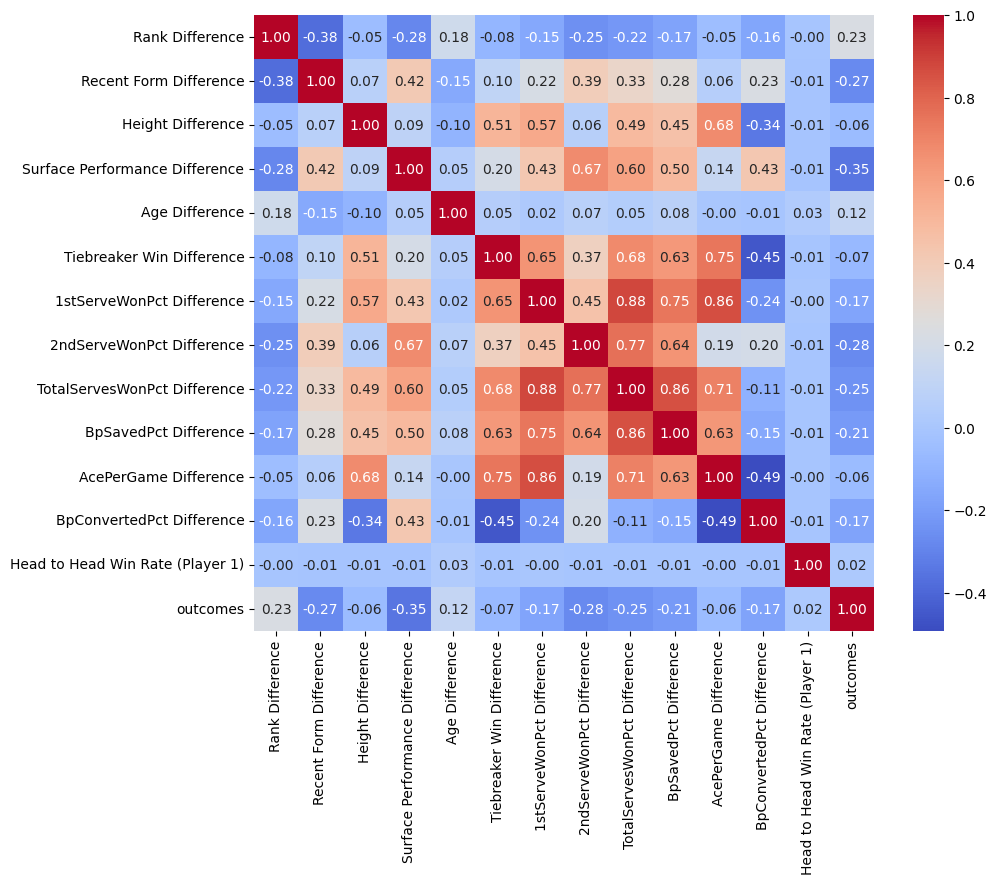

In [ ]:
#Plotting Correltaion Matrix
correlation_matrix = all_matches_df_extended.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

**Note:**

The Correlation Matrix is a bit tricky due to some representations.

**Outcomes:**

Because a player 1 win is represented by 0 and player 2 win is represented by 1, for features such as surface perforamnce difference where the greater the feature the greater the difference between player 1 and 2 a negative correlataion actually represents a positive relationship towards a player 1 win. This is becqause the greater the difference the more likely outcomes is "lower" aka towards player 1 = 0.

**Rank:**

The Rank Difference feature favors player 1 when it is lower -> as Player 1 Rank - Player 2 Rank favors Player 1 when Player 1 is a lowered rank team.

*In general, when percieving the Correlation Matrix it is important to gauge both features to percieve what the correlation is telling.*

#**Models and Tests**

###**Baseline Standard - Guessing Purely on Rank of Each Player**

In [ ]:
correct_guesses = ((all_matches_df_extended['Rank Difference'] < 0) & (all_matches_df_extended['outcomes'] == 0) |
                   (all_matches_df_extended['Rank Difference'] > 0) & (all_matches_df_extended['outcomes'] == 1)).sum()

TP = ((all_matches_df_extended['Rank Difference'] < 0) & (all_matches_df_extended['outcomes'] == 0)).sum()
FP = ((all_matches_df_extended['Rank Difference'] > 0) & (all_matches_df_extended['outcomes'] == 0)).sum()
FN = ((all_matches_df_extended['Rank Difference'] < 0) & (all_matches_df_extended['outcomes'] == 1)).sum()

total_matches = len(all_matches_df_extended)
accuracy_base = correct_guesses / total_matches


precision_base = TP / (TP + FP)
recall_base = TP / (TP + FN)
f1_score_base = 2 * (precision_base * recall_base) / (precision_base + recall_base)

print(f'Precision: {precision_base:.4f}')
print(f'F1 Score: {f1_score_base:.4f}')
print(f'Accuracy of guessing purely on ranked player: {accuracy_base:.4f}')

Precision: 0.6556
F1 Score: 0.6676
Accuracy of guessing purely on ranked player: 0.6569


###**The Logistic Regression Test**

In [ ]:
warnings.filterwarnings('ignore', category=ConvergenceWarning)

param_grid_lr = {'C': [0.001, 0.01, 0.1], 'penalty': ['l2']}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='accuracy', verbose = 0)

grid_lr.fit(X_train, y_train)

best_lr_model = grid_lr.best_estimator_
y_pred = best_lr_model.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred)
precision_lr = precision_score(y_test, y_pred)
recall_lr = recall_score(y_test, y_pred)
f1_lr = f1_score(y_test, y_pred)

print('----------------------------------------------------')
print(f'LR Accuracy: {accuracy_lr:.4f}')
print(f'LR Precision: {precision_lr:.4f}')
print(f'LR Recall: {recall_lr:.4f}')
print('----------------------------------------------------')

----------------------------------------------------
LR Accuracy: 0.6638
LR Precision: 0.6479
LR Recall: 0.6244
----------------------------------------------------


####**Feature Importance Plot**

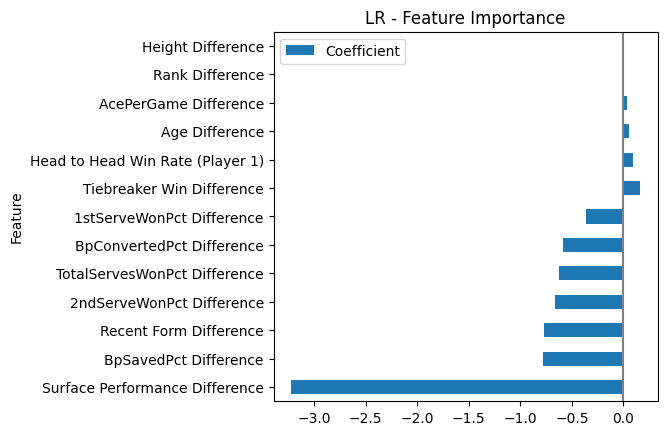

In [ ]:
coefficients = best_lr_model.coef_[0]
feature_names = X_train.columns

coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)

coefficients_df.plot(kind='barh', x='Feature', y='Coefficient')
plt.title('LR - Feature Importance')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)
plt.show()

####**Confusion Matrix**

-----------------------------------
LR F1 Score: 0.6360
LR ROC AUC: 0.7266
-----------------------------------


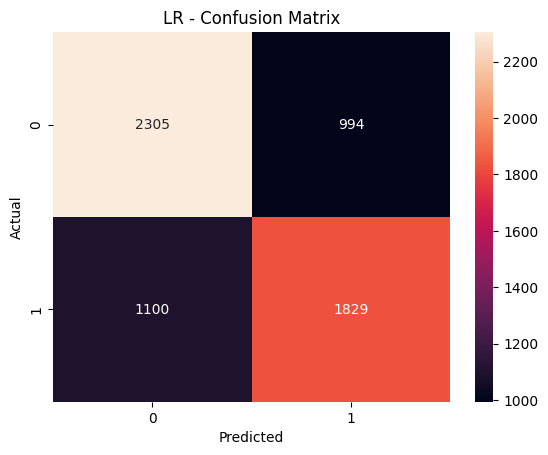

In [ ]:
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_lr_model.predict_proba(X_test)[:,1])
print('-----------------------------------')
print(f'LR F1 Score: {f1:.4f}')
print(f'LR ROC AUC: {roc_auc:.4f}')
print('-----------------------------------')
#print('LR - Classification Report:')
#print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('LR - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

####**ROC and AUC Plot**

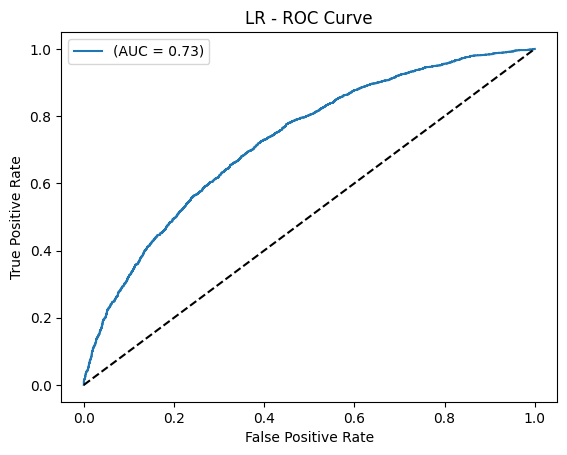

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, best_lr_model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=f'(AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR - ROC Curve')
plt.legend(loc='best')
plt.show()

###**Random Forest**

####**Code**

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)

grid_rf.fit(X_train, y_train)

best_rf_model = grid_rf.best_estimator_

y_pred_rf = best_rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])

print('----------------------------------------------------')
print(f'RF Accuracy: {accuracy_rf:.4f}')
print(f'RF Precision: {precision_rf:.4f}')
print(f'RF Recall: {recall_rf:.4f}')
print(f'RF F1 Score: {f1_rf:.4f}')
print(f'RF ROC AUC: {roc_auc_rf:.4f}')
print('----------------------------------------------------')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


----------------------------------------------------
RF Accuracy: 0.7640
RF Precision: 0.7603
RF Recall: 0.7276
RF F1 Score: 0.7435
RF ROC AUC: 0.8682
----------------------------------------------------


####**Feature Importance Plot RF**

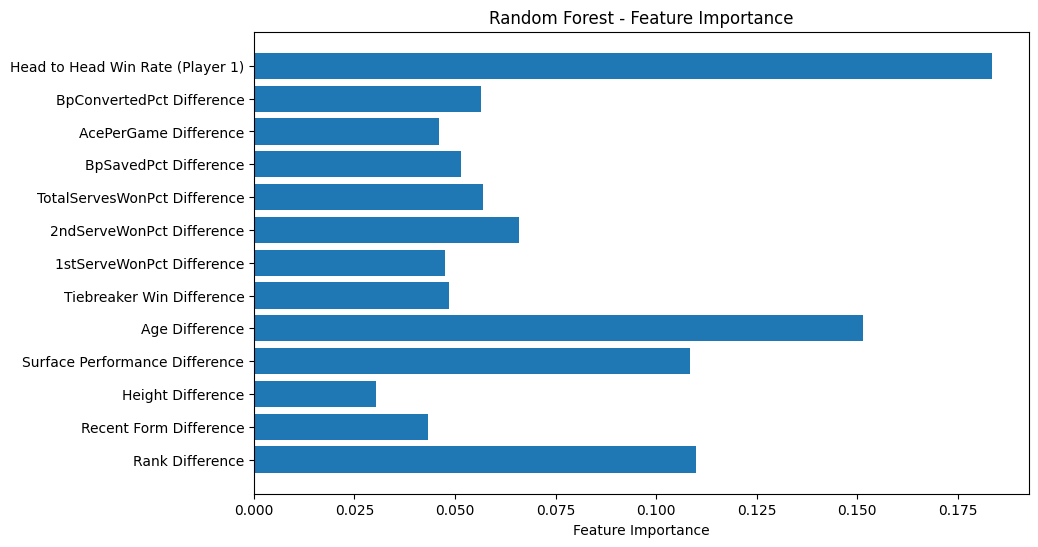

In [ ]:
feature_importances = best_rf_model.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(range(len(feature_importances)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance')
plt.show()


####**Confusion Matrix RF**

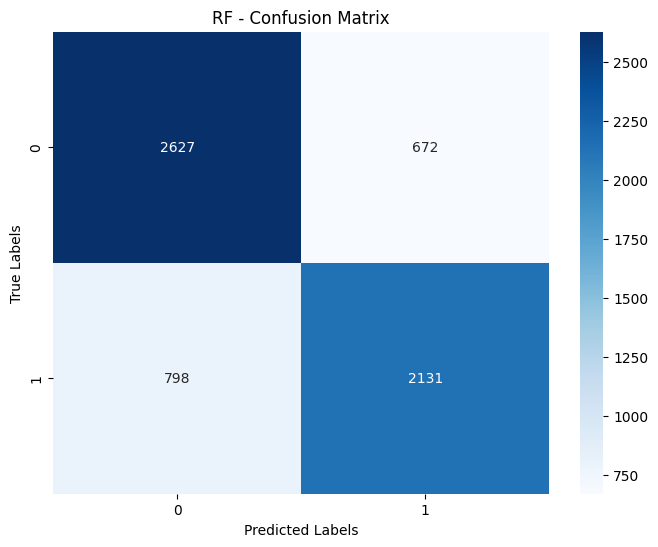

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('RF - Confusion Matrix')
plt.show()

####**ROC and AUC Plot**


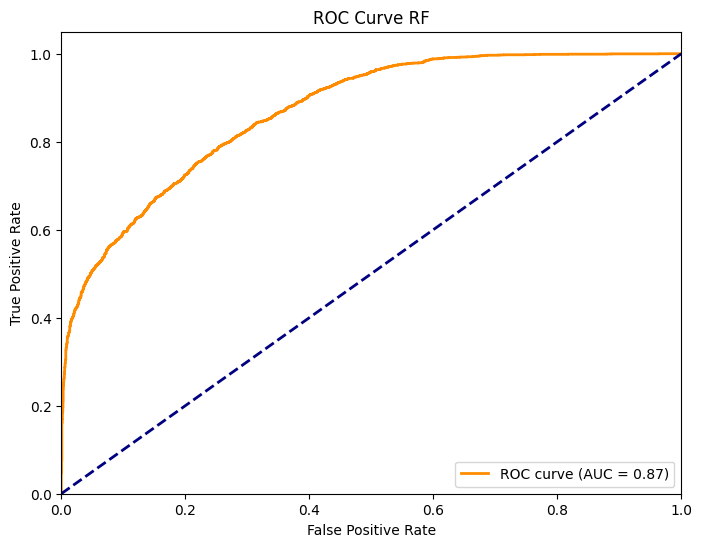

In [ ]:
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve RF')
plt.legend(loc='lower right')
plt.show()

###**Support Vector Machine**

####**Code**

In [ ]:
'''
I did not have enough time to include the Support Vector Machine Model in my last run before submitting.
The SVM model took too long to run.
In my practice runs the SVM model did not perform significanly better than the average model.

I include the Code here to illustrate the steps take to include it.

param_grid_svm = {
    'C': [0.1, 1],
    'kernel': ['linear', 'poly'],
}

grid_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)

grid_svm.fit(X_train, y_train)

best_svm_model = grid_svm.best_estimator_

y_pred_svm = best_svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print('----------------------------------------------------')
print(f'SVM Classifier Metrics:')
print(f'Accuracy: {accuracy_svm:.4f}')
print(f'Precision: {precision_svm:.4f}')
print(f'Recall: {recall_svm:.4f}')
print(f'F1 Score: {f1_svm:.4f}')
print('----------------------------------------------------')
'''

####**Confusion Matrix RF**

In [ ]:
'''
conf_matrix = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - SVM')
plt.show()
'''

####**ROC and AUC Plot**


In [ ]:
'''
y_pred_proba = best_svm_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM - ROC Curve')
plt.legend(loc='lower right')
plt.show()
'''

###**K Nearest Neighbors**

####**Code**

In [ ]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)

grid_knn.fit(X_train, y_train)

best_knn_model = grid_knn.best_estimator_

y_pred_knn = best_knn_model.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

print('----------------------------------------------------')
print(f'K-Nearest Neighbors Classifier Metrics:')
print(f'Accuracy: {accuracy_knn:.4f}')
print(f'Precision: {precision_knn:.4f}')
print(f'Recall: {recall_knn:.4f}')
print(f'F1: {f1_knn:.4f}')
print('----------------------------------------------------')

----------------------------------------------------
K-Nearest Neighbors Classifier Metrics:
Accuracy: 0.6654
Precision: 0.6486
Recall: 0.6296
F1: 0.6389
----------------------------------------------------


####**Confusion Matrix K-Neighbors**

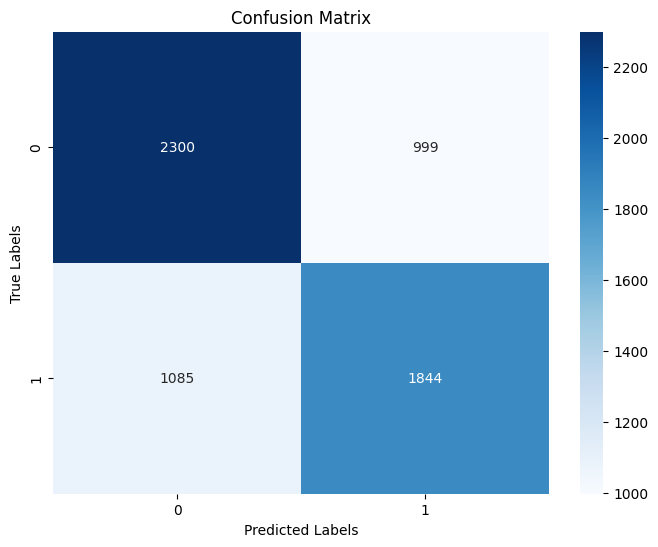

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

####**ROC and AUC Plot K Neighbors**


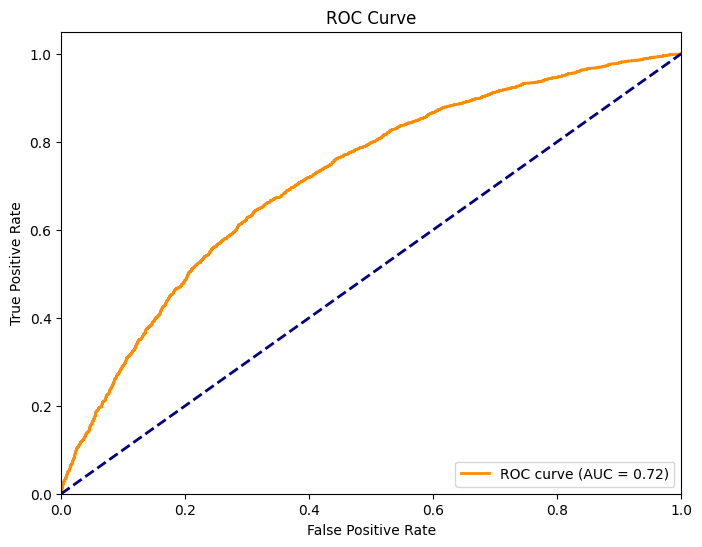

In [ ]:
y_pred_proba = best_knn_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

###**Naive Bayes**

####**Code**

In [ ]:
nb = GaussianNB()

nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

print('--------------------------------------------')
print(f'Naive Bayes Classifier Metrics:')
print(f'Accuracy: {accuracy_nb:.4f}')
print(f'Precision: {precision_nb:.4f}')
print(f'Recall: {recall_nb:.4f}')
print(f'F1: {f1_nb:.4f}')
print('--------------------------------------------')

--------------------------------------------
Naive Bayes Classifier Metrics:
Accuracy: 0.6477
Precision: 0.6256
Recall: 0.6248
F1: 0.6252
--------------------------------------------


####**Confusion Matrix Naive Bayes**

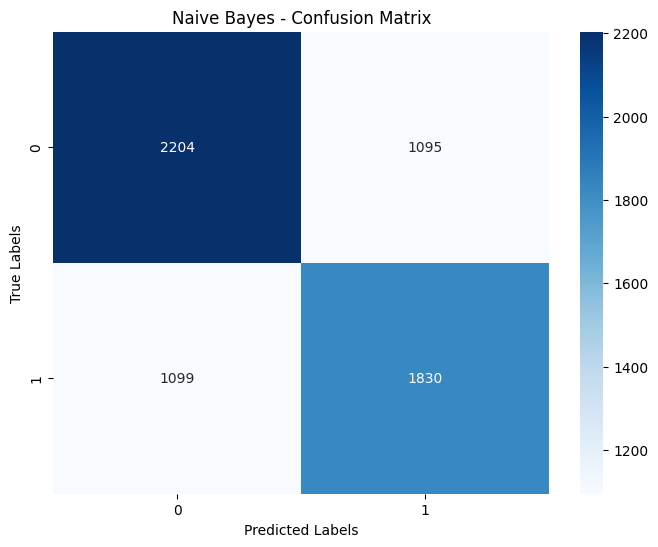

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Naive Bayes - Confusion Matrix')
plt.show()

####**ROC and AUC Plot Naive Bayes**


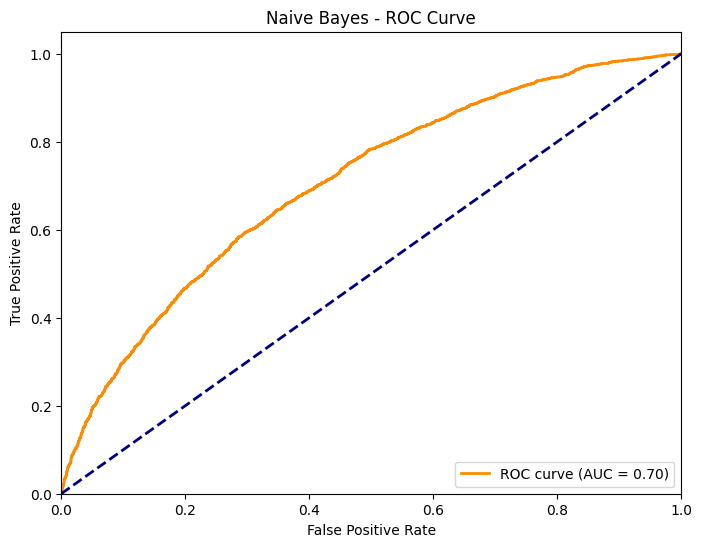

In [ ]:
y_pred_proba = nb.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes - ROC Curve')
plt.legend(loc='lower right')
plt.show()

###**Neural Network based Models**

195/195 [==============================] - 0s 1ms/step
---------------------------------------------------
Model 1 Precision: 0.6496
Model 1 Recall: 0.6531
Model 1 F1 Score: 0.6513
Model 1 Accuracy: 67.1162%
---------------------------------------------------
195/195 [==============================] - 0s 1ms/step
---------------------------------------------------
Model 2 Precision: 0.6411
Model 2 Recall: 0.5671
Model 2 F1 Score: 0.6018
Model 2 Accuracy: 64.7078%
---------------------------------------------------
195/195 [==============================] - 0s 1ms/step
---------------------------------------------------
Model 3 Precision: 0.6305
Model 3 Recall: 0.6111
Model 3 F1 Score: 0.6207
Model 3 Accuracy: 64.8683%
---------------------------------------------------
195/195 [==============================] - 0s 1ms/step
---------------------------------------------------
Model 4 Precision: 0.6437
Model 4 Recall: 0.5193
Model 4 F1 Score: 0.5748
Model 4 Accuracy: 63.8728%
------------

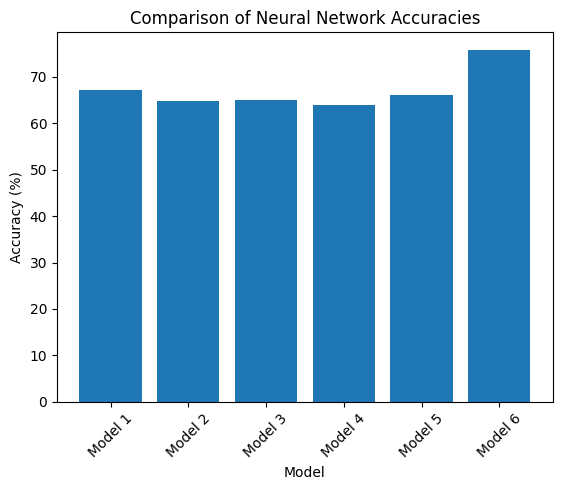

In [ ]:
X_train_scaled = X_train
X_test_scaled = X_test

initial_learning_rate = .00001
decay_rate = 0.99

lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=decay_rate,
    staircase=True
)

adam = Adam(learning_rate=lr_schedule)

model1 = Sequential([
    Dense(64, input_dim=len(features), activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model1.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

initial_learning_rate = .00001
decay_rate = 0.99

lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=decay_rate,
    staircase=True
)

adam = Adam(learning_rate=lr_schedule)

model2 = Sequential([
    Dense(64, input_dim=len(features), activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

initial_learning_rate = .00001
decay_rate = 0.99

lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=decay_rate,
    staircase=True
)

adam = Adam(learning_rate=lr_schedule)

model3 = Sequential([
    Dense(128, input_dim=len(features), activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])
model3.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

initial_learning_rate = .00001
decay_rate = 0.99

lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=decay_rate,
    staircase=True
)

adam = Adam(learning_rate=lr_schedule)

model4 = Sequential([
    Dense(128, input_dim=len(features), activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model4.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

initial_learning_rate = .00001
decay_rate = 0.99

lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=decay_rate,
    staircase=True
)

adam = Adam(learning_rate=lr_schedule)

model5 = Sequential([
    Dense(128, input_dim=len(features), activation='relu', kernel_regularizer=l1(0.001)),
    Dense(64, activation='relu', kernel_regularizer=l1(0.001)),
    Dense(1, activation='sigmoid')
])
model5.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


initial_learning_rate = .00001
decay_rate = 0.99

lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=decay_rate,
    staircase=True
)

adam = Adam(learning_rate=lr_schedule)

model6 = Sequential([
    Dense(1024, input_dim=len(features), activation='relu'),
    Dense(512, activation='relu'),
    Dropout(.5),
    Dense(384, activation='relu'),
    Dropout(.5),
    Dense(256, activation='relu'),
    Dropout(.3),
    Dense(192, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(.3),
    Dense(96, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(.3),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dropout(.1),
    Dense(1, activation='sigmoid')
])

model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Model 1 -> NN
model1.fit(X_train_scaled, y_train, epochs=250, batch_size=50, validation_split=0.2, verbose=0)
scores = model1.evaluate(X_test_scaled, y_test)
model1_acc = scores[1] * 100

y_pred1 = model1.predict(X_test_scaled)
y_pred1 = (y_pred1 > 0.5).astype("int32")
model1_precision = precision_score(y_test, y_pred1)
model1_recall = recall_score(y_test, y_pred1)
model1_f1 = f1_score(y_test, y_pred1)
print('---------------------------------------------------')
print(f"Model 1 Precision: {model1_precision:.4f}")
print(f"Model 1 Recall: {model1_recall:.4f}")
print(f"Model 1 F1 Score: {model1_f1:.4f}")
print(f"Model 1 Accuracy: {model1_acc :.4f}%")
print('---------------------------------------------------')

#Model 2 -> NN
model2.fit(X_train_scaled, y_train, epochs=250, batch_size=50, validation_split=0.2,verbose=0)
scores = model2.evaluate(X_test_scaled, y_test)
model2_acc = scores[1] * 100
y_pred2 = model2.predict(X_test_scaled)
y_pred2 = (y_pred2 > 0.5).astype("int32")
model2_precision = precision_score(y_test, y_pred2)
model2_recall = recall_score(y_test, y_pred2)
model2_f1 = f1_score(y_test, y_pred2)
print('---------------------------------------------------')
print(f"Model 2 Precision: {model2_precision:.4f}")
print(f"Model 2 Recall: {model2_recall:.4f}")
print(f"Model 2 F1 Score: {model2_f1:.4f}")
print(f"Model 2 Accuracy: {model2_acc :.4f}%")
print('---------------------------------------------------')

#Model 3 -> NN
model3.fit(X_train_scaled, y_train, epochs=250, batch_size=50, validation_split=0.2,verbose=0)
scores = model3.evaluate(X_test_scaled, y_test)
model3_acc = scores[1] * 100

y_pred3 = model3.predict(X_test_scaled)
y_pred3 = (y_pred3 > 0.5).astype("int32")
model3_precision = precision_score(y_test, y_pred3)
model3_recall = recall_score(y_test, y_pred3)
model3_f1 = f1_score(y_test, y_pred3)
print('---------------------------------------------------')
print(f"Model 3 Precision: {model3_precision:.4f}")
print(f"Model 3 Recall: {model3_recall:.4f}")
print(f"Model 3 F1 Score: {model3_f1:.4f}")
print(f"Model 3 Accuracy: {model3_acc :.4f}%")
print('---------------------------------------------------')

#Model 4 -> NN
model4.fit(X_train_scaled, y_train, epochs=250, batch_size=64, validation_split=0.2,verbose=0)
scores = model4.evaluate(X_test_scaled, y_test)
model4_acc = scores[1] * 100

y_pred4 = model4.predict(X_test_scaled)
y_pred4 = (y_pred4 > 0.5).astype("int32")
model4_precision = precision_score(y_test, y_pred4)
model4_recall = recall_score(y_test, y_pred4)
model4_f1 = f1_score(y_test, y_pred4)
print('---------------------------------------------------')
print(f"Model 4 Precision: {model4_precision:.4f}")
print(f"Model 4 Recall: {model4_recall:.4f}")
print(f"Model 4 F1 Score: {model4_f1:.4f}")
print(f"Model 4 Accuracy: {model4_acc :.4f}%")
print('---------------------------------------------------')

#Model 5 -> NN
model5.fit(X_train_scaled, y_train, epochs=250, batch_size=64, validation_split=0.2,verbose=0)
scores = model5.evaluate(X_test_scaled, y_test)
model5_acc = scores[1] * 100

y_pred5 = model5.predict(X_test_scaled)
y_pred5 = (y_pred5 > 0.5).astype("int32")
model5_precision = precision_score(y_test, y_pred5)
model5_recall = recall_score(y_test, y_pred5)
model5_f1 = f1_score(y_test, y_pred5)
print('---------------------------------------------------')
print(f"Model 5 Precision: {model5_precision:.4f}")
print(f"Model 5 Recall: {model5_recall:.4f}")
print(f"Model 5 F1 Score: {model5_f1:.4f}")
print(f"Model 5 Accuracy: {model5_acc :.4f}%")
print('---------------------------------------------------')

#Model 6 -> NN
model6.fit(X_train_scaled, y_train, epochs=250, batch_size=32, validation_split=0.2,verbose=0)
scores = model6.evaluate(X_test_scaled, y_test)
model6_acc = scores[1] * 100

y_pred6 = model6.predict(X_test_scaled)
y_pred6 = (y_pred6 > 0.5).astype("int32")
model6_precision = precision_score(y_test, y_pred6)
model6_recall = recall_score(y_test, y_pred6)
model6_f1 = f1_score(y_test, y_pred6)
print('---------------------------------------------------')
print(f"Model 6 Precision: {model6_precision:.4f}")
print(f"Model 6 Recall: {model6_recall:.4f}")
print(f"Model 6 F1 Score: {model6_f1:.4f}")
print(f"Model 6 Accuracy: {model6_acc :.4f}%")
print('---------------------------------------------------')

#Plotting All Neural Net Accuracies Against Each Other
model_accuracies = [model1_acc, model2_acc, model3_acc, model4_acc, model5_acc, model6_acc]
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4','Model 5','Model 6']

plt.bar(model_names, model_accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
plt.title('Comparison of Neural Network Accuracies')
plt.show()


**XGBoost**

In [ ]:
xgb_model = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=6,
    objective='binary:logistic',
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred_xg = xgb_model.predict(X_test)

xgboost_acc = accuracy_score(y_test, y_pred_xg)
xgboost_precision = precision_score(y_test, y_pred_xg)
xgboost_recall = recall_score(y_test, y_pred_xg)
xgboost_f1 = f1_score(y_test, y_pred_xg)

print(f"XGBoost Accuracy: {xgboost_acc:.4f}")
print(f"XGBoost Precision: {xgboost_precision:.4f}")
print(f"XGBoost Recall: {xgboost_recall:.4f}")
print(f"XGBoost F1 Score: {xgboost_f1:.4f}")

XGBoost Accuracy: 0.7746
XGBoost Precision: 0.7798
XGBoost Recall: 0.7255
XGBoost F1 Score: 0.7517


#**Results and Evaluation**

##**Accuracy**

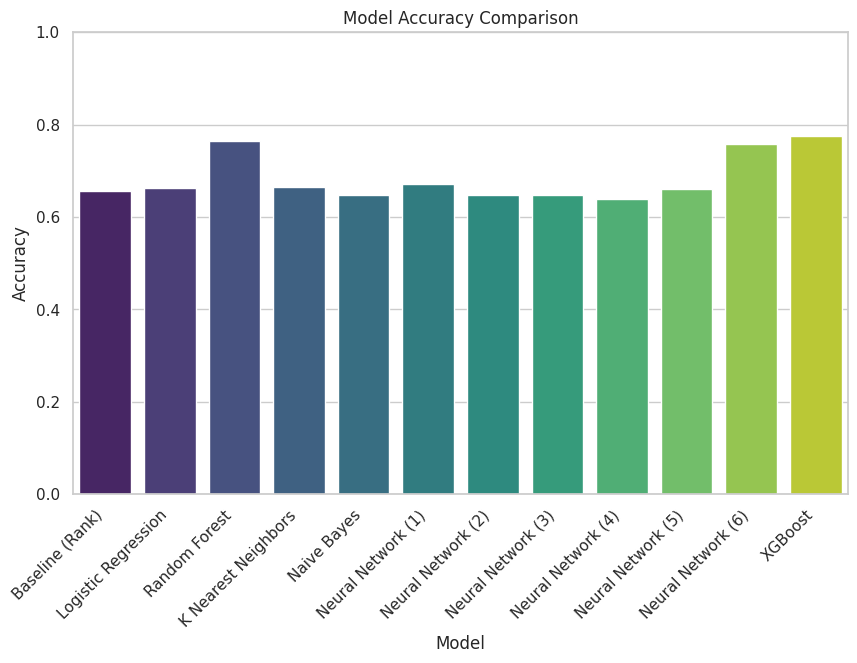

In [ ]:
model_accuracies = {
    'Baseline (Rank)': accuracy_base,
    'Logistic Regression': accuracy_lr,
    'Random Forest': accuracy_rf,
    'K Nearest Neighbors': accuracy_knn,
    'Naive Bayes': accuracy_nb,
    'Neural Network (1)': model1_acc/100,
    'Neural Network (2)': model2_acc/100,
    'Neural Network (3)': model3_acc/100,
    'Neural Network (4)': model4_acc/100,
    'Neural Network (5)': model5_acc/100,
    'Neural Network (6)': model6_acc/100,
    'XGBoost': xgboost_acc,
}

models = list(model_accuracies.keys())

accuracies = list(model_accuracies.values())

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.barplot(x=models, y=accuracies, palette='viridis')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1])

plt.show()

##**Recall, Precision, and F1 Scores**

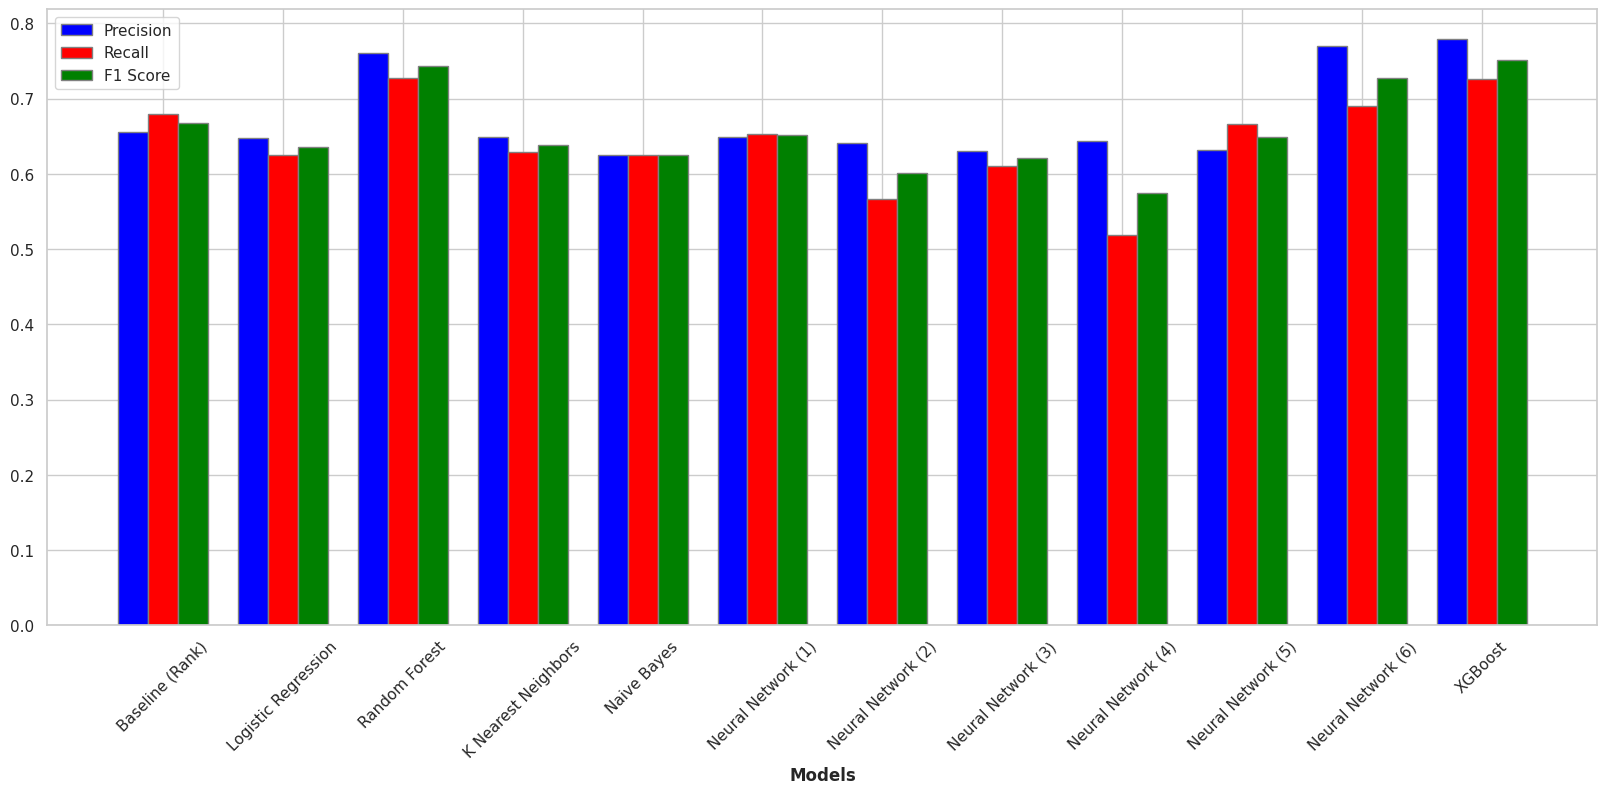

In [ ]:
model_precisions = {
    'Baseline (Rank)': precision_base,
    'Logistic Regression': precision_lr,
    'Random Forest': precision_rf,
    'K Nearest Neighbors': precision_knn,
    'Naive Bayes': precision_nb,
    'Neural Network (1)': model1_precision,
    'Neural Network (2)': model2_precision,
    'Neural Network (3)': model3_precision,
    'Neural Network (4)': model4_precision,
    'Neural Network (5)': model5_precision,
    'Neural Network (6)': model6_precision,
    'XGBoost': xgboost_precision,
}

model_recalls = {
    'Baseline (Rank)': recall_base,
    'Logistic Regression': recall_lr,
    'Random Forest': recall_rf,
    'K Nearest Neighbors': recall_knn,
    'Naive Bayes': recall_nb,
    'Neural Network (1)': model1_recall,
    'Neural Network (2)': model2_recall,
    'Neural Network (3)': model3_recall,
    'Neural Network (4)': model4_recall,
    'Neural Network (5)': model5_recall,
    'Neural Network (6)': model6_recall,
    'XGBoost': xgboost_recall,
}

model_f1s = {
    'Baseline (Rank)': f1_score_base,
    'Logistic Regression': f1_lr,
    'Random Forest': f1_rf,
    'K Nearest Neighbors': f1_knn,
    'Naive Bayes': f1_nb,
    'Neural Network (1)': model1_f1,
    'Neural Network (2)': model2_f1,
    'Neural Network (3)': model3_f1,
    'Neural Network (4)': model4_f1,
    'Neural Network (5)': model5_f1,
    'Neural Network (6)': model6_f1,
    'XGBoost': xgboost_f1,
}

models = list(model_precisions.keys())

precisions = list(model_precisions.values())
recalls = list(model_recalls.values())
f1s = list(model_f1s.values())

barWidth = 0.25

r1 = np.arange(len(precisions))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.figure(figsize=(20, 8))

plt.bar(r1, precisions, color='blue', width=barWidth, edgecolor='grey', label='Precision')
plt.bar(r2, recalls, color='red', width=barWidth, edgecolor='grey', label='Recall')
plt.bar(r3, f1s, color='green', width=barWidth, edgecolor='grey', label='F1 Score')

plt.xlabel('Models', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(precisions))], models, rotation=45)
plt.legend()

plt.show()

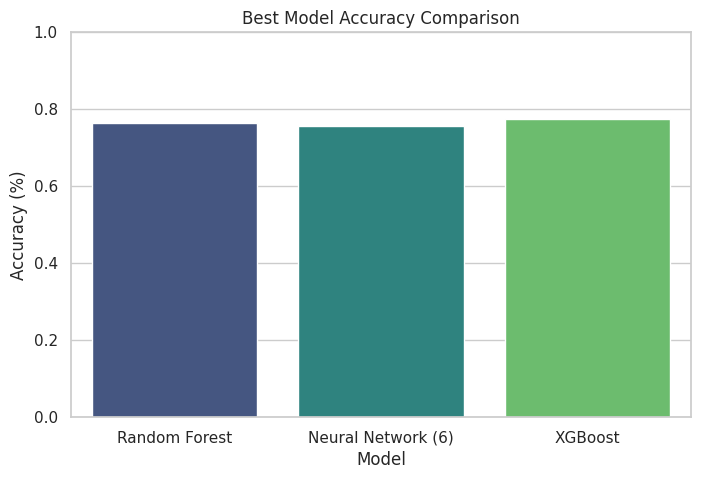

In [ ]:
best_models = ['Neural Network (6)', 'Random Forest', 'XGBoost']


best_model_accuracies = {model: acc for model, acc in model_accuracies.items() if model in best_models}


sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(x=list(best_model_accuracies.keys()), y=list(best_model_accuracies.values()), palette='viridis')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Best Model Accuracy Comparison')
plt.ylim([0, 1])
plt.show()

##**Summary**

In all, it appears the 3 best models at predicting ATP tounrment match winners was the Random Forest, the XGBoost, and one of the Neural Network Models. The rest of the models in this analysis were all within 2 percentage points of the baseline rank.

Here is the Accuracy Rankings of the Top 3 Models


1.   XGBoost: 77.46%
2.   Random Forest: 76.40%
3.   Neural Network (6): 75.70%

The 3 top models all performed about 10 points higher than the baseline accuracy, illustrating that these models did indeed learn to predict winners better than purely selecting the higher ranked player.

The performance of these models indicate that it is possible to more accurately predict tennis match winners with using the data.

Out of these 3 models, it appears the Random Forest model is the most balanced, as the Neural Network (6) model and the XgBoost tend to favor precision over recall.

Due to these three models being within 2% and with no favor of precision/recall for this dataset, more analysis would need to be taken to distinguish which model is the guarenteed "Best Model." Additionally, the F1 scores for the 3 models are comparable, so no distinguishing factor from that evluation either

In all, while there is always future work to do, the high f1 and accuracy scores of the three top models indicate that -> Yes, a data driven approach can be used to better predict ATP Tour Tennis Matches.



